# Tugas Besar 1 IF3270 Pembelajaran Mesin Feedforward Neural Network

### Activation Function


In [14]:
import numpy as np

def tanh(x):
    return np.tanh(x)

def softmax(x):
    e = np.exp(np.clip(x, -100, 100))
    return e / np.sum(e, axis=1, keepdims=True)

def linear(x):
    return x

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


### Function Derivative

In [15]:
import numpy as np

# turunan fungsi aktivasi
def linearDerivative(net):
    return 1

def tanDerivative(net):
    return  1 - np.tanh(net) ** 2

import numpy as np

def softmaxDerivative(net, threshold=100):
    net = np.array(net)
    batch_size, num_neurons = net.shape

    softmax_output = np.exp(np.clip(net, -100, 100))
    softmax_output /= np.sum(softmax_output, axis=1, keepdims=True)

    if num_neurons > threshold:
        return softmax_output * (1 - softmax_output)

    softmax_jacobian = np.zeros((batch_size, num_neurons, num_neurons))

    for b in range(batch_size):
        for i in range(num_neurons):
            for j in range(num_neurons):
                if i == j:
                    softmax_jacobian[b, i, j] = softmax_output[b, i] * (1 - softmax_output[b, j])
                else:
                    softmax_jacobian[b, i, j] = -softmax_output[b, i] * softmax_output[b, j]

    return softmax_jacobian


def sigmoidDerivative(net):
    net = np.array(net)
    return net * (1 - net)

def reluDerivative(net):
    net = np.array(net)
    return np.where(net > 0, 1, 0)

# turunan fungsi loss
def mseDerivative(o, target):
    o = np.array(o)
    batch_size, num_neurons = o.shape
    target = np.array(target).T
    return (o - target) * 2/batch_size

def binaryDerivative(o, target):
    o = np.array(o)
    target = np.array(target).T
    batch_size, num_neurons = o.shape
    return (o - target)/(o*(1-o)) * 1/batch_size

def categoricalDerivative(o, target):
    o = np.array(o)
    target = np.array(target).T
    batch_size, num_neurons = o.shape
    return -(target / o) * (1 / batch_size)

# hitung gradien
def outputLayer(o, net, target, activFunc, LossFunc):
    if LossFunc == "binary":
        loss =  binaryDerivative(o, target)
    elif LossFunc == "categorical":
        loss = categoricalDerivative(o, target)
    else:
        loss =  mseDerivative(o, target)

    if activFunc=="softmax":
        jacobian = softmaxDerivative(net)
        if jacobian.ndim == 2:
            diag_jacobian = jacobian
        else:
            diag_jacobian = np.diagonal(jacobian, axis1=1, axis2=2)
        return loss * diag_jacobian.T
    elif activFunc =="tanh":
        return loss * tanDerivative(net).T
    elif activFunc == "sigmoid":
        return loss * sigmoidDerivative(net).T
    elif activFunc == "relu":
        return loss * reluDerivative(net).T
    else:
        return loss * linearDerivative(net)


def hiddenLayer(w, net, delta, activFunc):
    if activFunc=="softmax":
        jacobian = softmaxDerivative(net)
        if jacobian.ndim == 2:
            diag_jacobian = jacobian
        else:
            diag_jacobian = np.diagonal(jacobian, axis1=1, axis2=2)
        return np.dot(w, delta) * diag_jacobian
    elif activFunc =="tanh":
        return np.dot(w, delta) * tanDerivative(net)
    elif activFunc == "sigmoid":
        return np.dot(w, delta) * sigmoidDerivative(net)
    elif activFunc == "relu":
        return np.dot(w, delta) * reluDerivative(net)
    else:
        return np.dot(w, delta) * linearDerivative(net)


### Layer Model

In [16]:
import numpy as np

class Layers:
    def __init__(self, n_inputs: int, n_neurons: int, activ_func, use_bias=1):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.activ_func = activ_func
        self.use_bias = use_bias

        self.weight = np.random.randn((n_inputs + use_bias), n_neurons)


### FFNN Model

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import sys
import time

class FFNN:
    def __init__(self, batch_size: int, learning_rate: float, epoch: int, verbose: int, loss_func, weight_init, seed=int):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.verbose = verbose
        self.loss_func = loss_func
        self.weight_init = weight_init
        self.loss_train_history = []
        self.loss_val_history = []
        self.seed = seed or None

        self.input_train: list[list[float]] = []
        self.input_val: list[list[float]] = []
        self.target_train: list[list[float]] = []
        self.target_val: list[list[float]] = []
        self.layers: list[Layers] = []
        self.delta_gradien: list[np.ndarray] = []

    def initDeltaGradien(self):
        self.delta_gradien = [np.zeros((layer.n_inputs+1, layer.n_neurons)) for layer in self.layers]

    def initWeight(self, lower_bound=-0.5, upper_bound=0.5, mean=0.0, variance=1.0):
        if self.weight_init == "custom":
            bxh = np.array([[0.35, 0.35]])
            wxh = np.array([[0.15, 0.25],
                            [0.2, 0.3]])
            self.layers[0].weight = np.vstack((bxh, wxh))
            bhy = np.array([[0.6, 0.6]])
            why = np.array([[0.4, 0.5],
                            [0.45, 0.55]])
            self.layers[1].weight = np.vstack((bhy, why))
        else:
            for layer in self.layers:
                fan_in = layer.n_inputs
                fan_out = layer.n_neurons

                if self.seed is not None:
                    np.random.seed(self.seed)
                if self.weight_init == "zero":
                    layer.weight = np.zeros((layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "uniform":
                    layer.weight = np.random.uniform(low=lower_bound, high=upper_bound, size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "normal":
                    layer.weight = np.random.normal(loc=mean, scale=np.sqrt(variance), size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "xavier":
                    variance_xavier = 2 / (fan_in + fan_out)
                    layer.weight = np.random.normal(loc=0.0, scale=np.sqrt(variance_xavier), size=(layer.n_inputs + 1, layer.n_neurons))
                elif self.weight_init == "he":
                    variance_he = 2 / fan_in
                    layer.weight = np.random.normal(loc=0.0, scale=np.sqrt(variance_he), size=(layer.n_inputs + 1, layer.n_neurons))

    def calcLoss(self, output: list[float], target: list[float]):
        if self.loss_func == "mse":
            return np.mean((np.array(target) - np.array(output)) ** 2)
        elif self.loss_func == "binary":
            output = np.array(output, dtype=np.float64)
            target = np.array(target, dtype=np.float64)
            return -np.mean(target * np.log(output + 1e-9) + (1 - target) * np.log(1 - output))
        elif self.loss_func == "categorical":
            return -np.mean(np.sum(target * np.log(output + 1e-9), axis=1))

    def updateWeight(self):
        for idx, layer in enumerate(self.layers):
            layer.weight -= self.delta_gradien[idx]

    def updateGradien(self, layer_idx: int, delta: np.ndarray, input: np.ndarray):
        grad = self.learning_rate * (np.array(input) @ np.array(delta).T)
        self.delta_gradien[layer_idx] = grad


    def addInputTarget(self, input_train: list[float], input_val: list[float], target_train: list[float], target_val: list[float]):
        self.input_train.append(input_train)
        self.input_val.append(input_val)
        self.target_train.append(target_train)
        self.target_val.append(target_val)

    def addHiddenLayer(self, layer: Layers):
        self.layers.append(layer)

    def plot_weight_distribution(self, layers_to_plot: list[int] = None):
        if layers_to_plot is None:
            layers_to_plot = list(range(len(self.layers)))

        num_layers = len(layers_to_plot)
        fig, ax = plt.subplots(1, num_layers, figsize=(5 * num_layers, 4), sharey=True)

        if num_layers == 1:
            ax = [ax]

        for i, layer_idx in enumerate(layers_to_plot):
            if layer_idx < 0 or layer_idx >= len(self.layers):
                print(f"Layer {layer_idx+1} tidak valid.")
                continue

            weights = self.layers[layer_idx].weight.flatten()
            ax[i].hist(weights, bins=30, alpha=0.7, color='b', edgecolor='black')
            ax[i].set_title(f'Layer {layer_idx+1}')
            ax[i].set_xlabel('Nilai Bobot')
            ax[i].set_ylabel('Frekuensi')
            ax[i].grid(True, linestyle='--', alpha=0.6)

        plt.suptitle('Distribusi Bobot Per Layer', fontsize=14)
        plt.tight_layout()
        plt.show()


    def plot_gradient_distribution(self, layers_to_plot: list[int] = None):
        if layers_to_plot is None:
            layers_to_plot = list(range(len(self.delta_gradien)))

        num_layers = len(layers_to_plot)
        fig, ax = plt.subplots(1, num_layers, figsize=(5 * num_layers, 4), sharey=True)

        if num_layers == 1:
            ax = [ax]

        for i, layer_idx in enumerate(layers_to_plot):
            if layer_idx < 0 or layer_idx >= len(self.delta_gradien):
                print(f"Layer {layer_idx+1} tidak valid.")
                continue

            grad = self.delta_gradien[layer_idx].flatten()
            ax[i].hist(grad, bins=30, alpha=0.7, color='r', edgecolor='black')
            ax[i].set_title(f'Layer {layer_idx+1}')
            ax[i].set_xlabel('Nilai Gradien')
            ax[i].set_ylabel('Frekuensi')
            ax[i].grid(True, linestyle='--', alpha=0.6)

        plt.suptitle('Distribusi Gradien Per Layer', fontsize=14)
        plt.tight_layout()
        plt.show()

    def feedForward(self):
        self.initWeight()
        start_time = time.time()
        self.loss_train_history = []
        self.loss_val_history = []

        for j in range(self.epoch):
            self.initDeltaGradien()
            train_error = 0
            epoch_start_time = time.time()

            for i, batch in enumerate(self.input_train):
                inputs: list[list[float]] = []
                nets: list[list[float]] = []
                self.initDeltaGradien()

                batch = np.array(batch)
                batch_size = batch.shape[0]
                bias = np.ones((batch_size, 1))
                current = np.hstack((bias, batch))
                inputs.append(current.copy().transpose().tolist())

                for layer in self.layers:
                    net = np.dot(current, layer.weight)
                    current = layer.activ_func(net)
                    nets.append(net.copy().transpose().tolist())
                    if layer != self.layers[-1]:
                        bias = np.ones((batch_size, 1))
                        current = np.hstack((bias, current))
                    inputs.append(current.copy().transpose().tolist())

                train_error += self.calcLoss(current, self.target_train[i])
                self.backPropagation(inputs, nets, self.target_train[i])
                self.updateWeight()

            self.loss_train_history.append(train_error)
            val_pred = self.predict(self.input_val)
            val_error = self.calcLoss(val_pred, self.target_val)
            self.loss_val_history.append(val_error)

            epoch_duration = time.time() - epoch_start_time
            total_elapsed = time.time() - start_time
            estimated_total_time = (total_elapsed / (j + 1)) * self.epoch
            eta = estimated_total_time - total_elapsed

            if self.verbose == 1:
                bar_length = 30
                progress = (j + 1) / self.epoch
                bar = "=" * int(bar_length * progress) + "-" * (bar_length - int(bar_length * progress))
                sys.stdout.write(f"\rEpoch {j+1}/{self.epoch} [{bar}] {progress*100:.1f}% - Training Loss: {train_error:.4f} - Validation Loss: {val_error:.4f} - {epoch_duration:.2f}s/epoch - ETA: {eta:.2f}s")
                sys.stdout.flush()

        print("\n         Training History          ")
        print("==================================")
        print("Epoch | Train Loss | Val Loss")
        print("-----------------------------------")
        for epoch, (train_loss, val_loss) in enumerate(zip(self.loss_train_history, self.loss_val_history)):
            print(f"{epoch+1:5d} |  {train_loss:.6f}  | {val_loss:.6f}")
        print("===================================")


    def backPropagation(self, inputs, netsLayer, target):
        # print(f"Total layers : {len(self.layers)}")
        i = len(self.layers) - 1
        delta1: np.ndarray = None

        while i >= -1:
            nets = np.array(netsLayer[i]).T

            if i == len(self.layers) - 1:  # Output layer
                if self.layers[i].activ_func == softmax:
                    delta1 = outputLayer(inputs[i+1], nets, target,"softmax",self.loss_func)
                elif self.layers[i].activ_func == tanh:
                    delta1 = outputLayer(inputs[i+1], nets, target,"tanh",self.loss_func)
                elif self.layers[i].activ_func == sigmoid:
                    delta1 = outputLayer(inputs[i+1], nets, target,"sigmoid",self.loss_func)
                elif self.layers[i].activ_func == relu:
                    delta1 = outputLayer(inputs[i+1], nets, target,"relu",self.loss_func)
                else: # linear
                    delta1 = outputLayer(inputs[i+1], nets, target,"linear",self.loss_func)

            else:  # Hidden layer
                # print("LAYERR",self.layers[i + 1].weight)
                if self.layers[i].activ_func == softmax:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "softmax")
                elif self.layers[i].activ_func == tanh:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "tanh")
                elif self.layers[i].activ_func == sigmoid:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "sigmoid")
                elif self.layers[i].activ_func == relu:
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "relu")
                else: # linear
                    delta2 = hiddenLayer(self.layers[i + 1].weight[1:], inputs[i+1][1:], delta1, "linear")

                self.updateGradien(i + 1, delta1,inputs[i+1])

                # print(f"Current input: {inputs[i+1][1:]}")
                # print(f"Current delta1: {delta1}")
                # print(f"Current All gradien: {self.delta_gradien}")
                # print(f"Current gradien: {self.delta_gradien[i + 1]}")
                delta1 = delta2

            i -= 1

    @staticmethod
    def visualize_network(ffnn):
        G = nx.DiGraph()
        layer_labels = []
        positions = {}

        for i in range(len(ffnn.input_train[0][0])):
            G.add_node(f"Input {i+1}")
            positions[f"Input {i+1}"] = (0, -i)
            layer_labels.append(f"Input {i+1}")

        prev_layer_neurons = [f"Input {i+1}" for i in range(len(ffnn.input_train[0][0]))]
        x_pos = 1

        for idx, layer in enumerate(ffnn.layers):
            current_layer_neurons = []
            bias_node = f"Bias {idx+1}"
            positions[bias_node] = (x_pos - 0.5, layer.n_neurons / 3)
            G.add_node(bias_node)
            layer_labels.append(bias_node)

            for n in range(layer.n_neurons):
                neuron_name = f"Layer {idx+1}\nNeuron {n+1}"
                G.add_node(neuron_name)
                current_layer_neurons.append(neuron_name)
                positions[neuron_name] = (x_pos, -n)
                layer_labels.append(neuron_name)

                weight_bias = layer.weight[0][n]
                gradient_bias = ffnn.delta_gradien[idx][0][n]
                G.add_edge(bias_node, neuron_name, weight=f"W: {weight_bias:.2f}\nG: {gradient_bias:.2f}")

                for prev_neuron in prev_layer_neurons:
                    weight_idx = prev_layer_neurons.index(prev_neuron) + 1
                    weight = layer.weight[weight_idx][n]
                    gradient = ffnn.delta_gradien[idx][weight_idx][n]
                    G.add_edge(prev_neuron, neuron_name, weight=f"W: {weight:.2f}\nG: {gradient:.2f}")

            prev_layer_neurons = current_layer_neurons
            x_pos += 1

        plt.figure(figsize=(12, 8))
        nx.draw(G, positions, with_labels=True, node_color='pink', node_size=1000, font_size=10, font_color='darkblue')

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, positions, edge_labels=edge_labels, font_color='red', label_pos=0.25)

        plt.title("Feed Forward Neural Network Visualization (Weights & Gradients)")
        plt.show()

    def save_model(self, filename):
        model_data = {
            "layers": [layer.weight for layer in self.layers],
            "batch_size": self.batch_size,
            "learning_rate": self.learning_rate,
            "epoch": self.epoch,
            "loss_func": self.loss_func
        }
        with open(filename, "wb") as f:
            pickle.dump(model_data, f)
        print(f"Model berhasil disimpan ke {filename}")

    def load_model(self, filename):
        with open(filename, "rb") as f:
            model_data = pickle.load(f)

        if len(model_data["layers"]) != len(self.layers):
            raise ValueError("Jumlah layer pada model yang dimuat tidak sesuai.")

        for layer, weight in zip(self.layers, model_data["layers"]):
            layer.weight = weight

        self.batch_size = model_data["batch_size"]
        self.learning_rate = model_data["learning_rate"]
        self.epoch = model_data["epoch"]
        self.loss_func = model_data["loss_func"]

        print(f"Model berhasil dimuat dari {filename}")

    def plot_loss(self):
        plt.figure(figsize=(4, 2))
        plt.plot(self.loss_train_history, label='Training Loss', color='blue')
        plt.plot(self.loss_val_history, label='Validation Loss', color='red', linestyle='dashed')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training & Validation Loss', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


    def predict(self, X):
        batch = np.array(X)
        if batch.ndim == 3:
            batch = batch.reshape(batch.shape[1], batch.shape[2])

        batch_size = batch.shape[0]
        bias = np.ones((batch_size, 1))
        current = np.hstack((bias, batch))

        for layer in self.layers:
            net = np.dot(current, layer.weight)
            current = layer.activ_func(net)
            if layer != self.layers[-1]:
                bias = np.ones((batch_size, 1))
                current = np.hstack((bias, current))
        return current


## Model Analysis

In [18]:
import numpy as np
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pickle

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

# Load dataset MNIST
print("Loading MNIST dataset...")
t0 = time.time()
train_samples = 5000
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='auto')
y = y.astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)
y_train_oh = one_hot_encode(y_train)
y_test_oh = one_hot_encode(y_test)
print(f"Data loaded in {time.time() - t0:.2f} seconds.")


Loading MNIST dataset...
Data loaded in 17.49 seconds.


In [19]:
def train_ffnn(depth, width, learning_rate, activation, weight_init):
    ffnn = FFNN(batch_size=train_samples, learning_rate=learning_rate, epoch=3, verbose=1, loss_func='mse', weight_init=weight_init, seed=42)

    for _ in range(depth - 1):
        ffnn.addHiddenLayer(Layers(n_inputs=784 if _ == 0 else width, n_neurons=width, activ_func=activation))

    output_layer = Layers(n_inputs=width, n_neurons=10, activ_func=softmax)
    ffnn.addHiddenLayer(output_layer)

    ffnn.addInputTarget(X_train.tolist(), X_test, y_train_oh.tolist(), y_test_oh.tolist())
    ffnn.feedForward()
    ffnn.plot_loss()
    ffnn.plot_weight_distribution()
    ffnn.plot_gradient_distribution()

    y_pred = ffnn.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = np.mean(y_pred_labels == y_test) * 100

    return ffnn, accuracy

### Pengaruh depth (banyak layer) dan width (banyak neuron per layer)


 Width 50 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1368 - Validation Loss: 0.1269 - 2.63s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.181270  | 0.136930
    2 |  0.135530  | 0.137960
    3 |  0.136832  | 0.126908


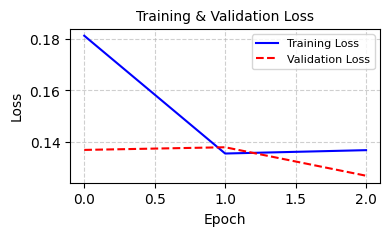

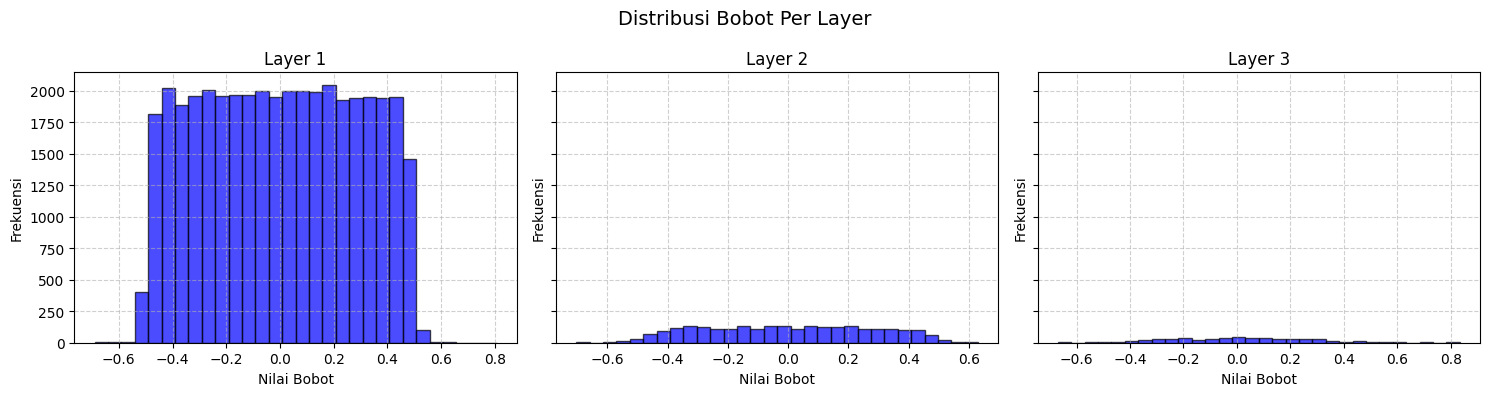

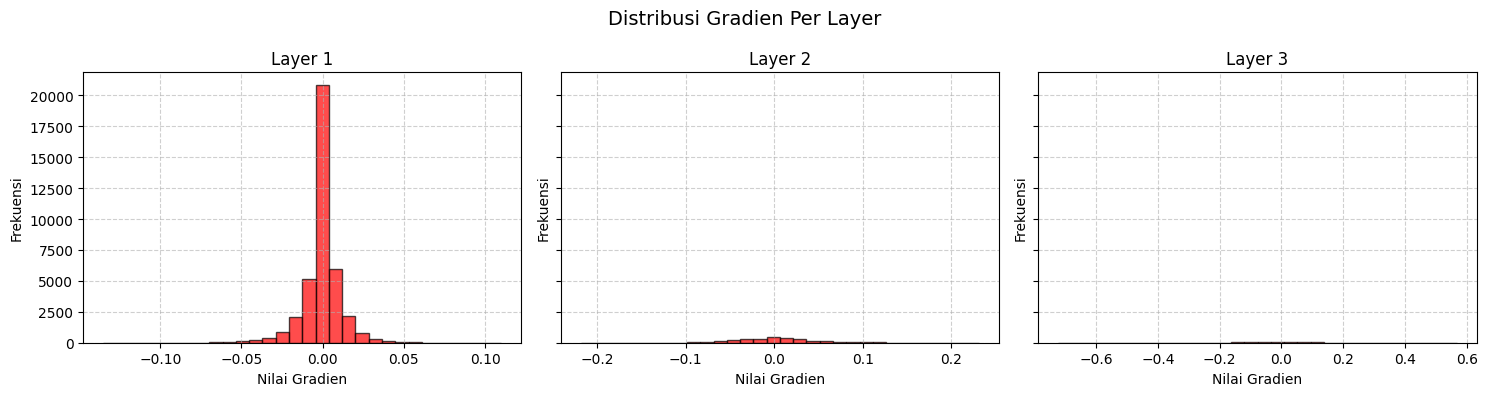


 Width 100 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1010 - Validation Loss: 0.1049 - 2.88s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.172684  | 0.112814
    2 |  0.113179  | 0.100869
    3 |  0.101046  | 0.104908


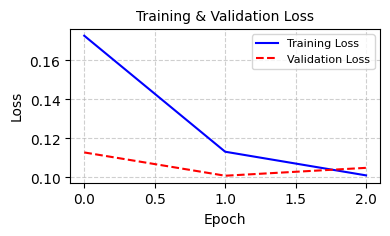

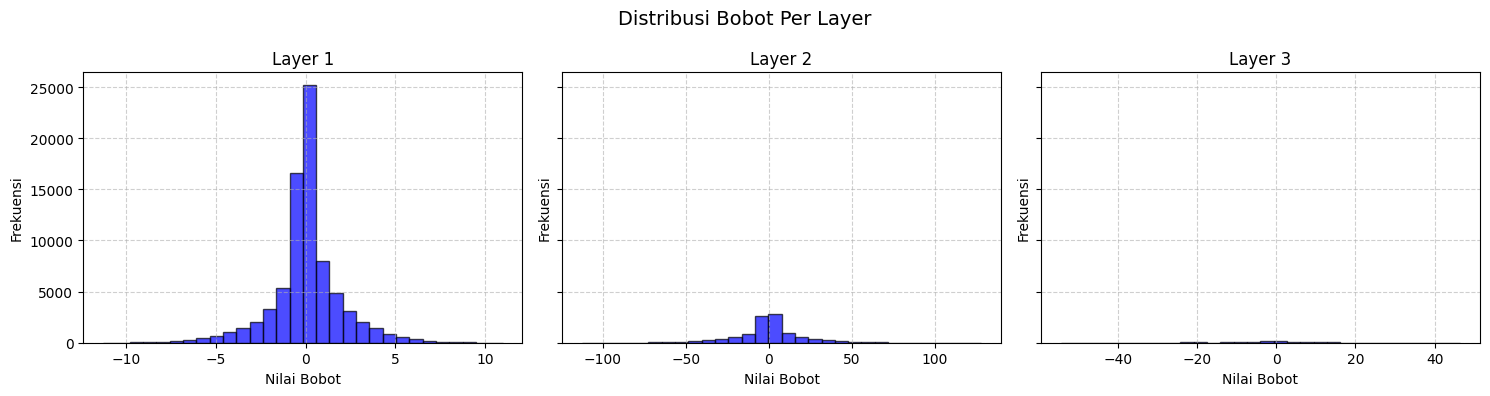

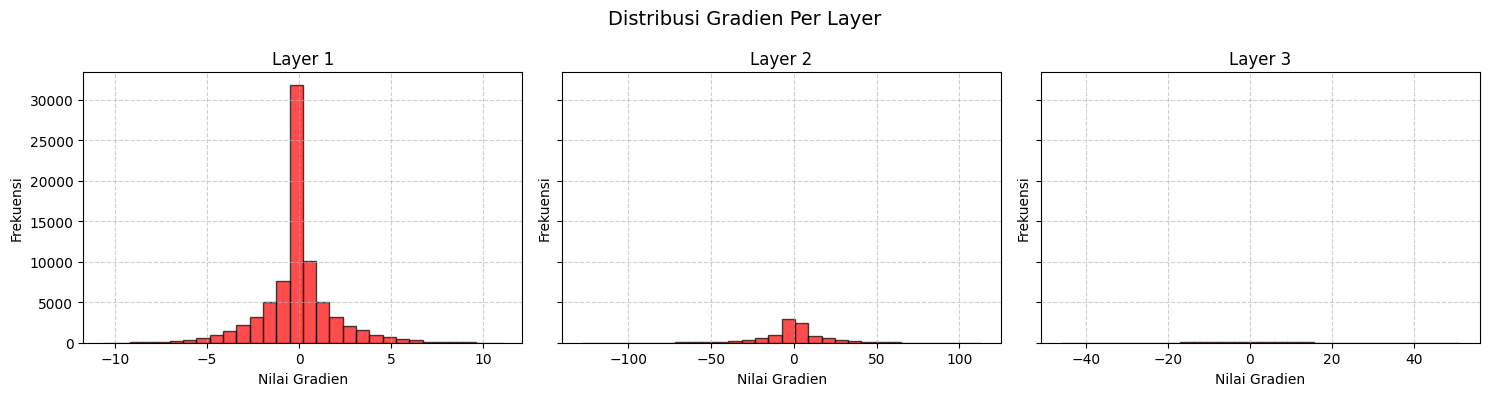


 Width 200 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1059 - Validation Loss: 0.0891 - 3.23s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.142471  | 0.111194
    2 |  0.110430  | 0.105584
    3 |  0.105912  | 0.089068


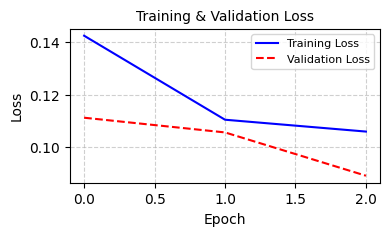

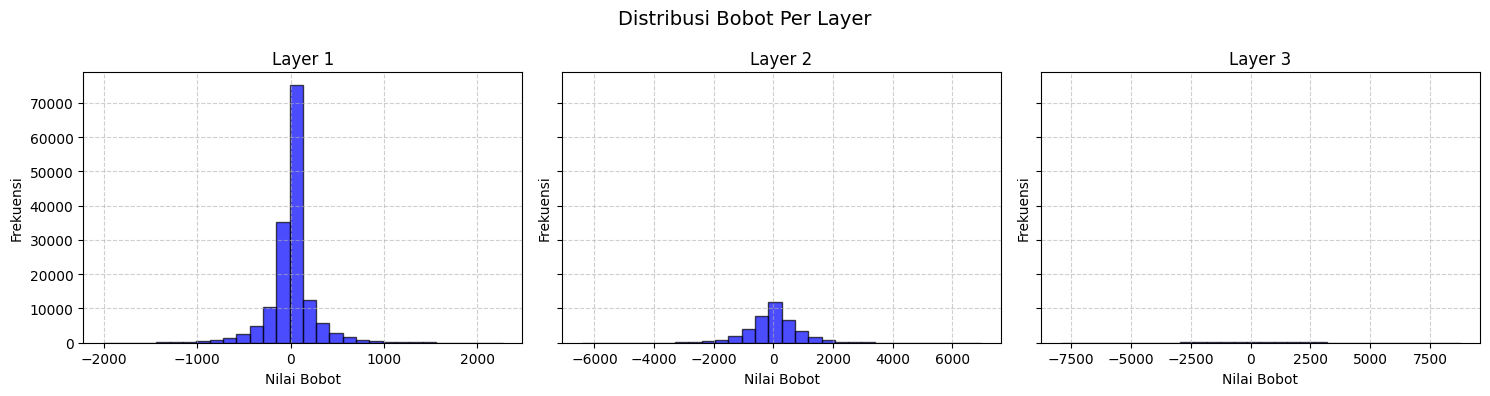

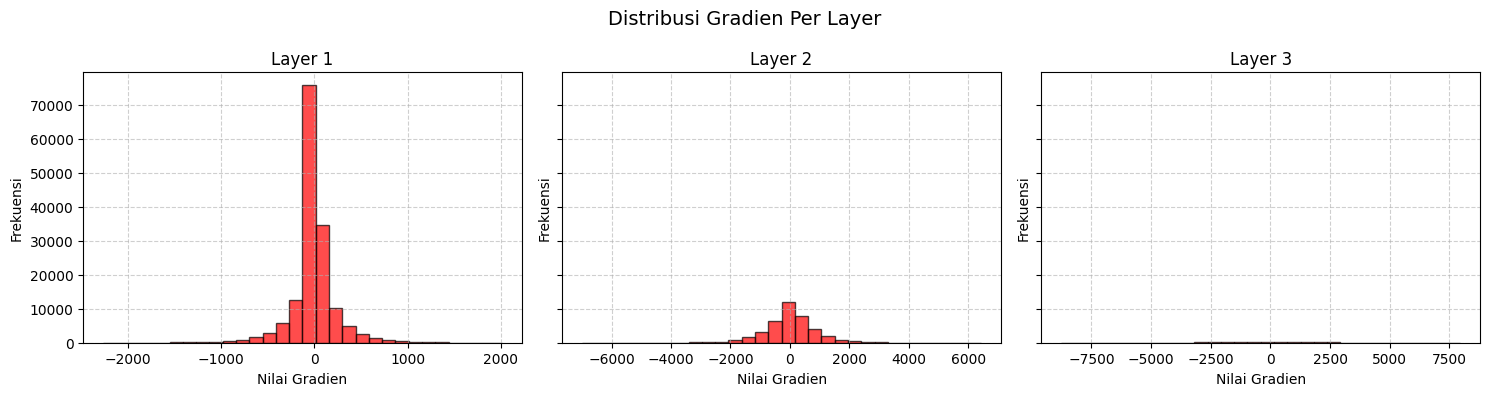

In [20]:
width_var = [50, 100, 200]

results = {}
for width in width_var:
    print(f"\n Width {width} Result\n")
    ffnn, acc = train_ffnn(depth=3, width=width, learning_rate=0.01, activation=linear, weight_init='uniform')
    results[f"Width {width}"] = acc

    Dari hasil pengujian di atas, terlihat bahwa semakin banyak jumlah width-nya (jumlah neuron) maka nilai training loss & validation loss cenderung akan turun yang menandakan bahwa model semakin baik dalam memahami pola tanpa terlalu overfitting. Dengan hasil nilai loss akhir dimulai dari 0.1171, 0.1055 dan 0.1068 untuk percobaan pada width 50, 100, dan 200. Selain itu, width 100 memberikan nilai terbaik karena ketika width ditingkatkan menjadi 200 terlihat bahwa penambahan width tidak memberikan perbedaan yang signifikan pada penurunan nilai loss dan hasilnya cenderung sedikit meningkat. Kecenderungan ini membuktikan bahwa terdapat suatu batas efektivitas ketika memperbesar width. 


    Peninjauan kedua dilakukan terhadap distribusi bobot per layer. Pada width 50, bobot cenderung lebih merata, menunjukkan pembelajaran yang lebih sederhana kurang mampu menangkap kompleksitas data. Sementara itu, pada width 100, distribusi bobot lebih normal, menandakan keseimbangan antara kapasitas model dan stabilitas pembelajaran. Di sisi lain, pada width 200, distribusi bobot semakin tajam dengan variansi besar, yang dapat berisiko menyebabkan eksploding gradients, yaitu saat nilai gradien selama backpropagation menjadi sangat besar yang menyebabkan perubahan bobot yang ekstrem dan ketidakstabilan dalam pelatihan. Sehingga perlu dikendalikan dengan teknik seperti normalisasi bobot atau regulasi yang baik. Oleh karena itu, width 100 memberikan keseimbangan yang baik antara generalisasi dan stabilitas dalam proses pembelajaran.

    Peninjauan terakhir dilakukan terhadap distribusi gradien per layer. Pada width 50, distribusi gradien menunjukkan nilai yang relatif kecil dan terpusat di sekitar nol, menandakan bahwa pembelajaran berjalan stabil tetapi mungkin kurang efektif dalam menangkap fitur kompleks. Pada width 100, pola distribusi tetap serupa, tetapi dengan sedikit peningkatan variansi, yang menunjukkan adanya peningkatan kapasitas model dalam menangkap informasi tanpa terlalu banyak risiko gradien yang ekstrem. Sementara itu, pada width 200, distribusi gradien menjadi lebih tajam dengan variansi yang sangat besar, yang dapat menyebabkan eksploding gradients dan membuat pembelajaran menjadi tidak stabil. Oleh karena itu, width 100 menjadi pilihan yang optimal untuk melakukan training pada model.


 Depth 2 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0837 - Validation Loss: 0.0701 - 2.63s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.171862  | 0.125952
    2 |  0.124972  | 0.088580
    3 |  0.083662  | 0.070112


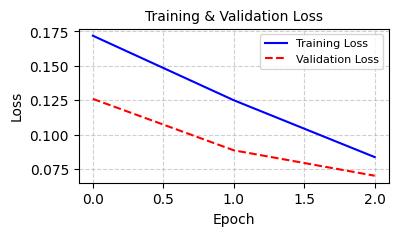

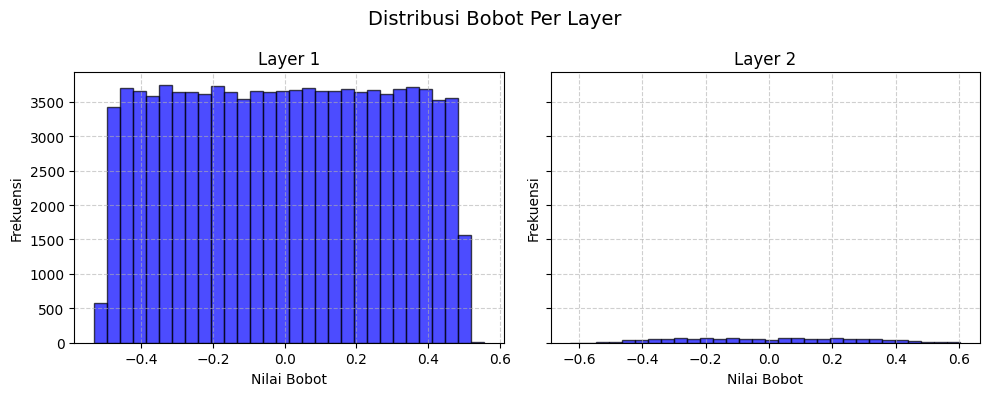

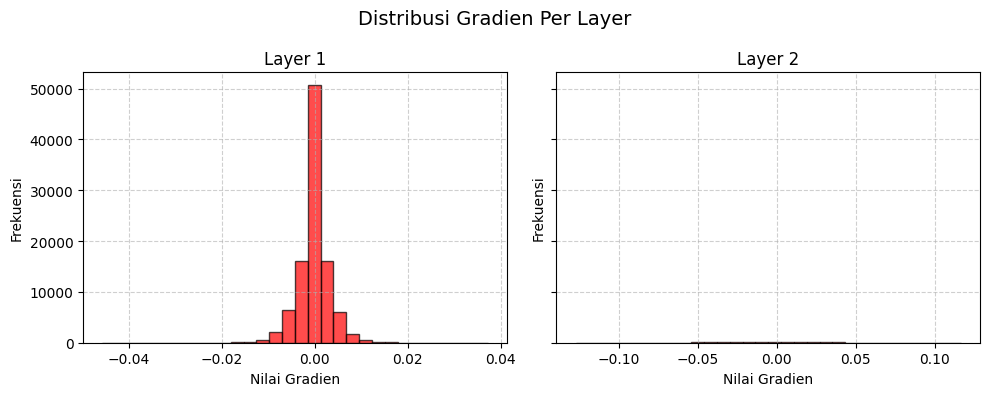


 Depth 4 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1076 - Validation Loss: 0.1065 - 3.16s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.121392  | 0.109180
    2 |  0.110011  | 0.106368
    3 |  0.107605  | 0.106510


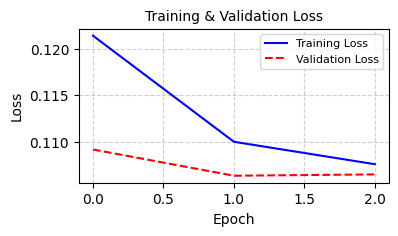

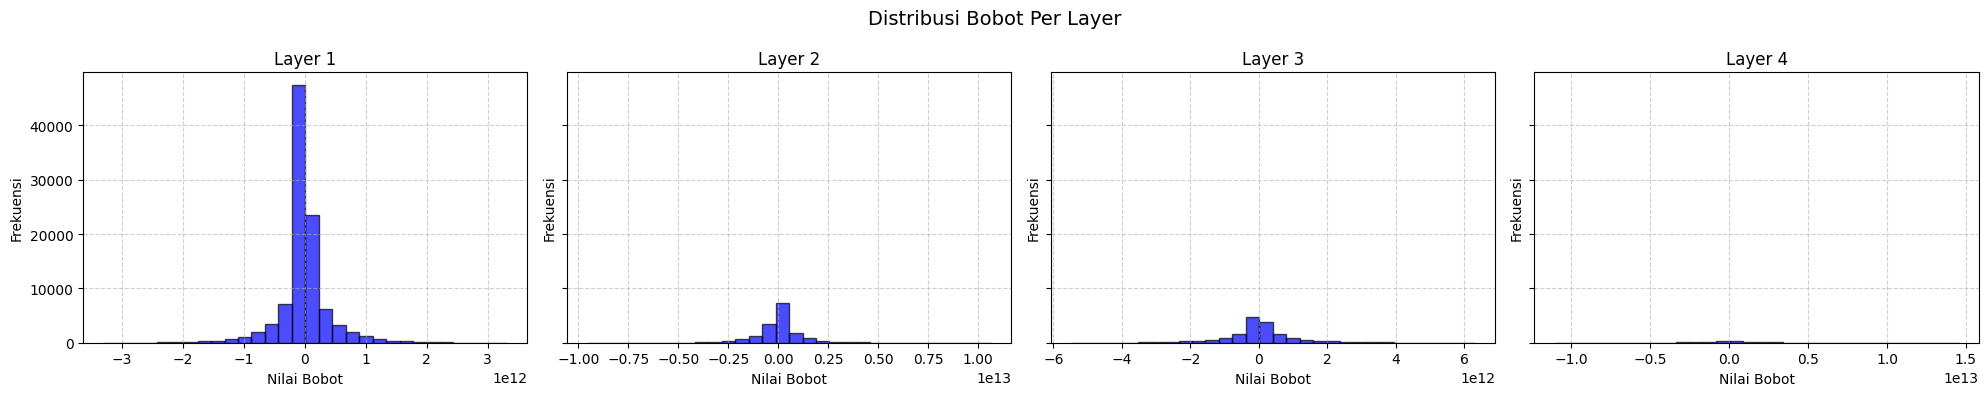

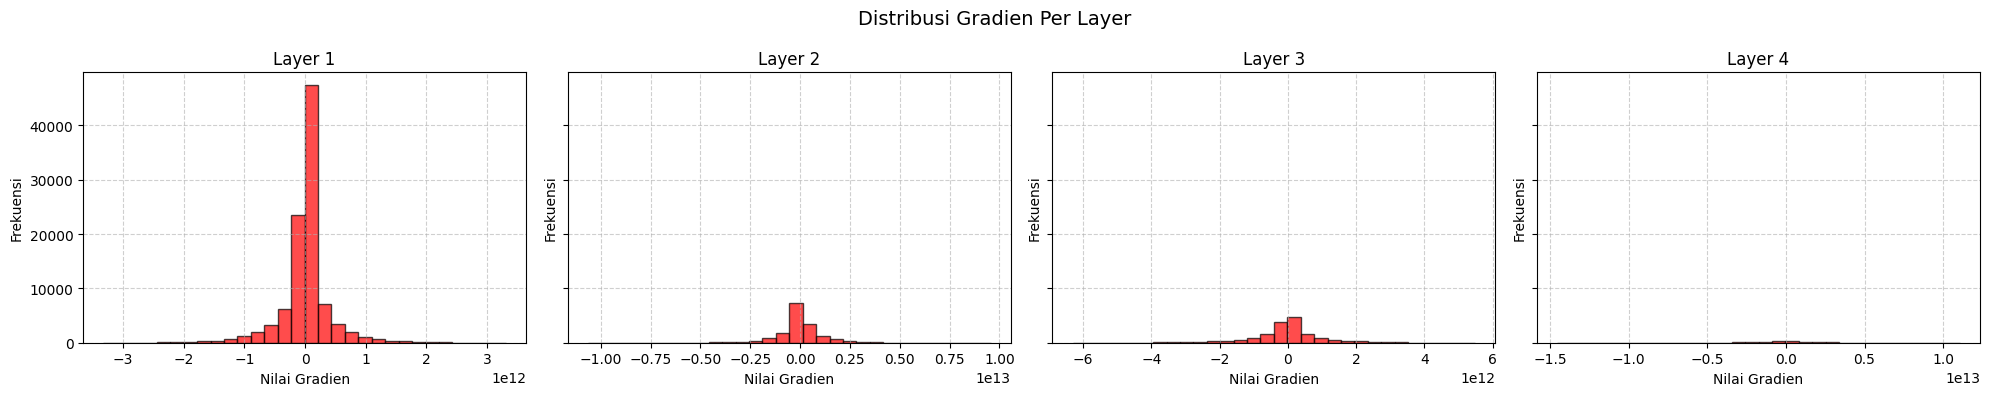


 Depth 6 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1075 - Validation Loss: nan - 3.78s/epoch - ETA: 0.00s6s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.104945  | 0.107211
    2 |  0.107381  | 0.107296
    3 |  0.107480  | nan


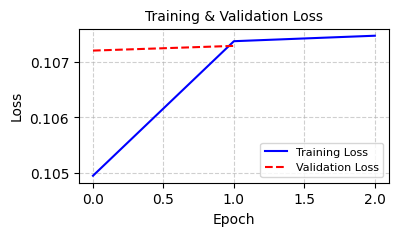

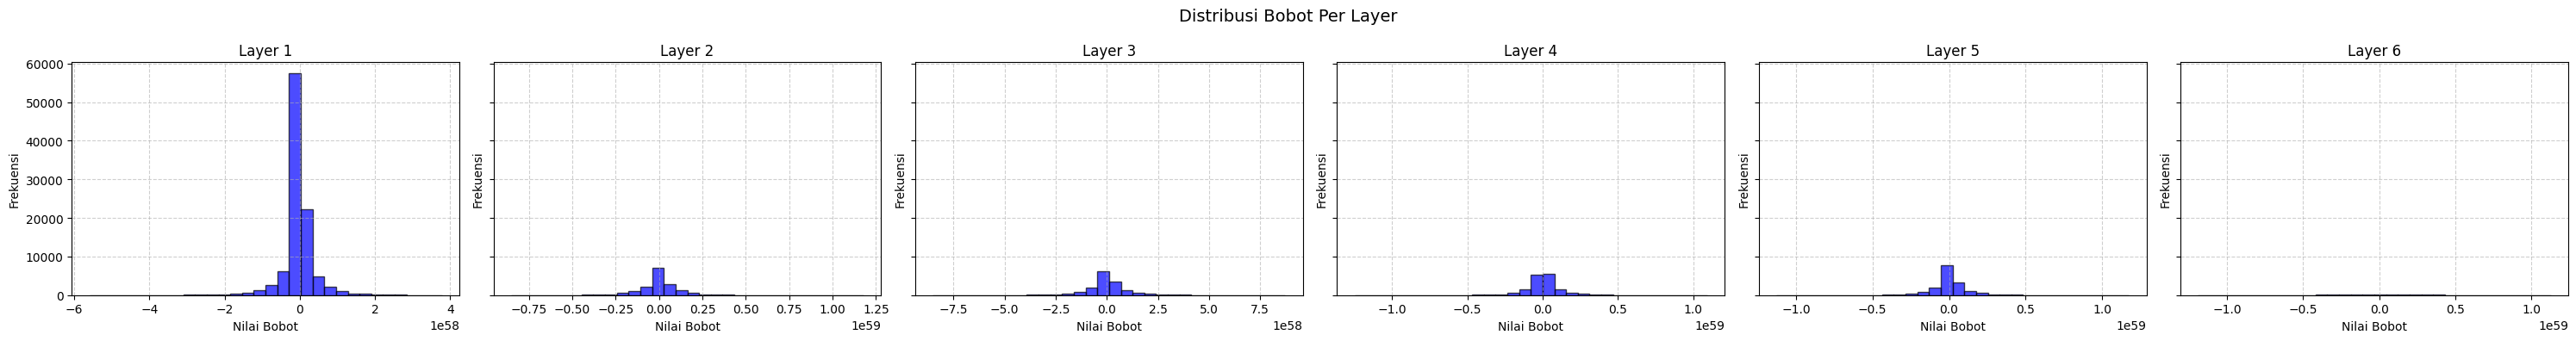

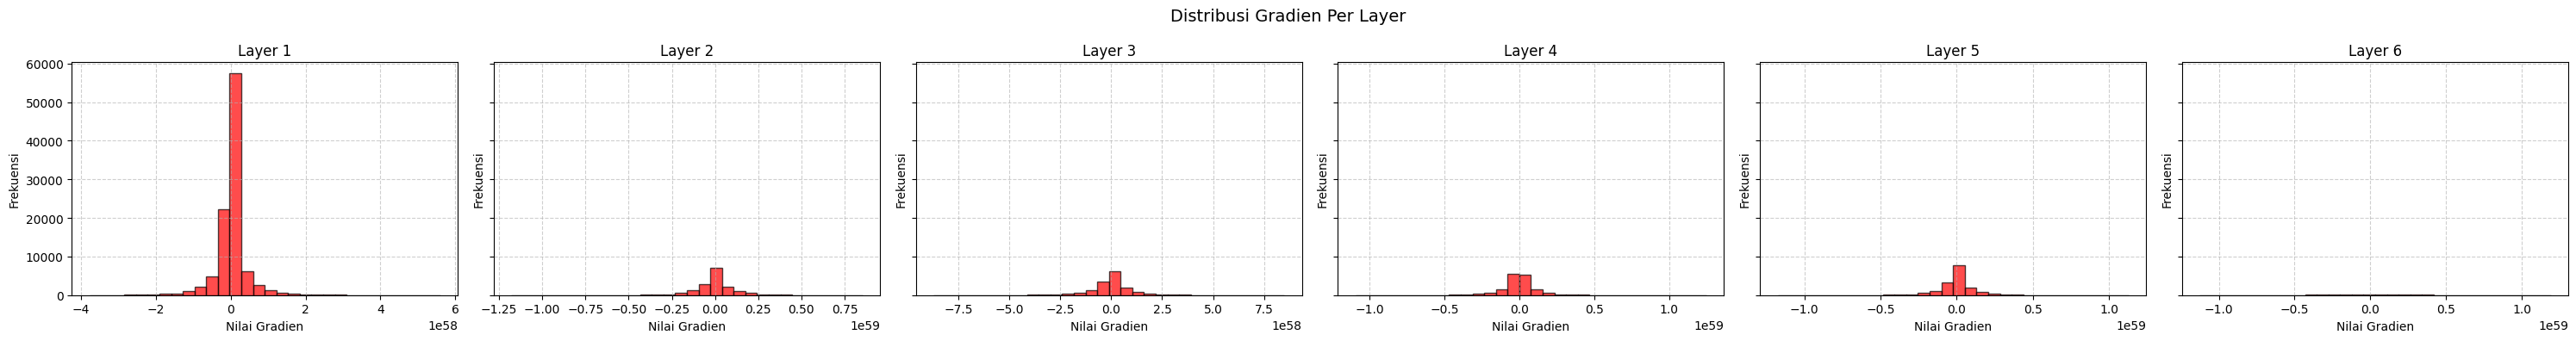

In [21]:
depth_var = [2, 4, 6]

results = {}
for depth in depth_var:
    print(f"\n Depth {depth} Result\n")
    ffnn, acc = train_ffnn(depth=depth, width=128, learning_rate=0.01, activation=linear, weight_init='uniform')
    results[f"Depth {depth}"] = acc

    Dari hasil pengujian, terlihat bahwa semakin dalam depth nya nilai training loss dan validation loss nya semakin meningkat. Terlihat pada grafik bahwa percobaan dengan menggunakan depth 2 penurunan nilai loss pada training dan validation cukup tajam dibandingkan dengan menggunakan depth 4 dan depth 6 yang cenderung meningkat terutama pada grafik validation. Hal ini menunjukkan bahwa semakin banyak nilai depth yang diberikan maka risiko terjadi overfit akan semakin meningkat yang menyebabkan nilai loss pada data validation meningkat. 


    Selanjutnya peninjauan kedua dilakukan terhadap distribusi bobot per layernya. Pada depth 2, distribusi bobot pada layer pertama tampak merata, menunjukkan bahwa pembelajaran terjadi dengan cukup baik, tetapi layer kedua memiliki bobot yang hampir tidak bervariasi cenderung berada pada sekitar nilai nol. Pada depth 4, bobot mulai terdistribusi dengan pola lebih tajam di sekitar nol, dan beberapa layer memiliki bobot dengan dengan nilai berskala besar. Pada depth 6, distribusi bobot semakin ekstrim dan nilai distribusi bobot yang meningkat, yang berpotensi menyebabkan eksploding gradients. Secara keseluruhan, model dengan depth yang lebih besar cenderung mengalami ketidakstabilan dalam pembelajaran jika tidak dikontrol dengan baik menggunakan normalisasi atau regularisasi.

    Terakhir peninjauan dilakukan terhadap distribusi gradien per layernya. Pada depth 2, distribusi gradien menunjukkan bahwa mayoritas nilai gradien terkonsentrasi di sekitar nol, terutama pada layer pertama, sementara layer kedua hampir tidak mengalami perubahan. Pada depth 4, nilai gradien semakin meningkat dengan nilai yang lebih besar, terutama pada layer pertama, yang menunjukkan potensi ketidakstabilan dalam pembelajaran. Pada depth 6, masalah ini semakin memburuk dengan distribusi gradien yang sangat tajam atau berarti sebagian besar nilai gradiennya sangat kecil dan terkonsentrasi di sekitar nol yang mengindikasikan masalah vanishing gradients. Selain itu, skala yang semakin besar, menandakan kemungkinan eksploding gradients. Secara keseluruhan, semakin dalam model maka akan semakin rentan terhadap masalah vanishing atau eksploding gradients. Masalah vanishing dapat menyebabkan model sulit untuk mengupdate bobot secara efektif karena tidak ada perubahan selama pembelajaran yang berdampak pada performansi yang semakin menurun. Selain itu, untuk masalah eksploding gradient menyebabkan pembaruan bobot sulit dikendalikan. Oleh karena itu, model ini masih memerlukan teknik lebih lanjut seperti normalisasi, regulasi, atau optimisasi yang lebih baik untuk menjaga stabilitas pembelajaran.

### Pengaruh Learning Rates


 Learning Rate 0.001 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1006 - Validation Loss: 0.0941 - 3.14s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.116129  | 0.119283
    2 |  0.120008  | 0.100657
    3 |  0.100605  | 0.094081


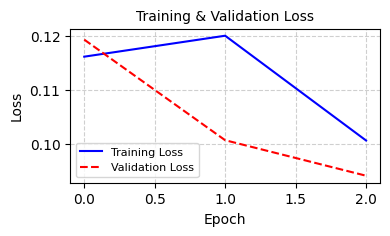

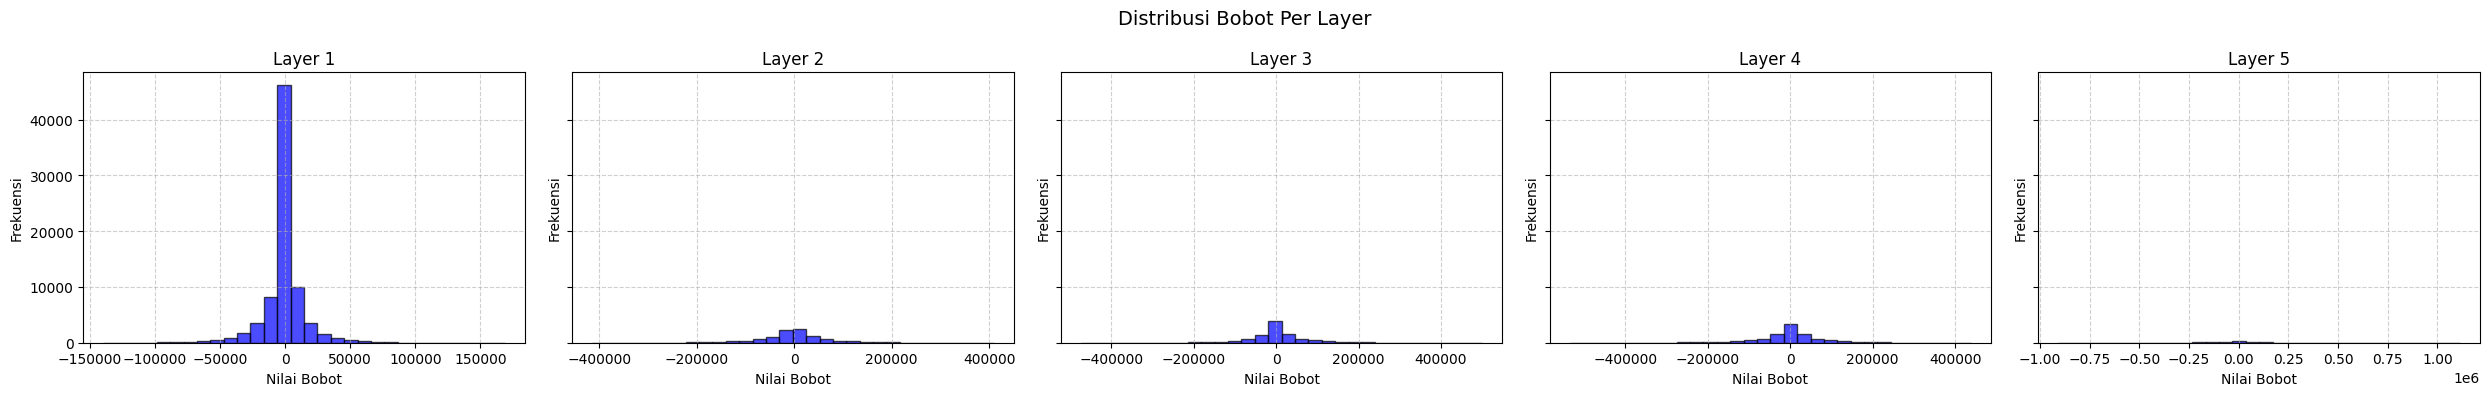

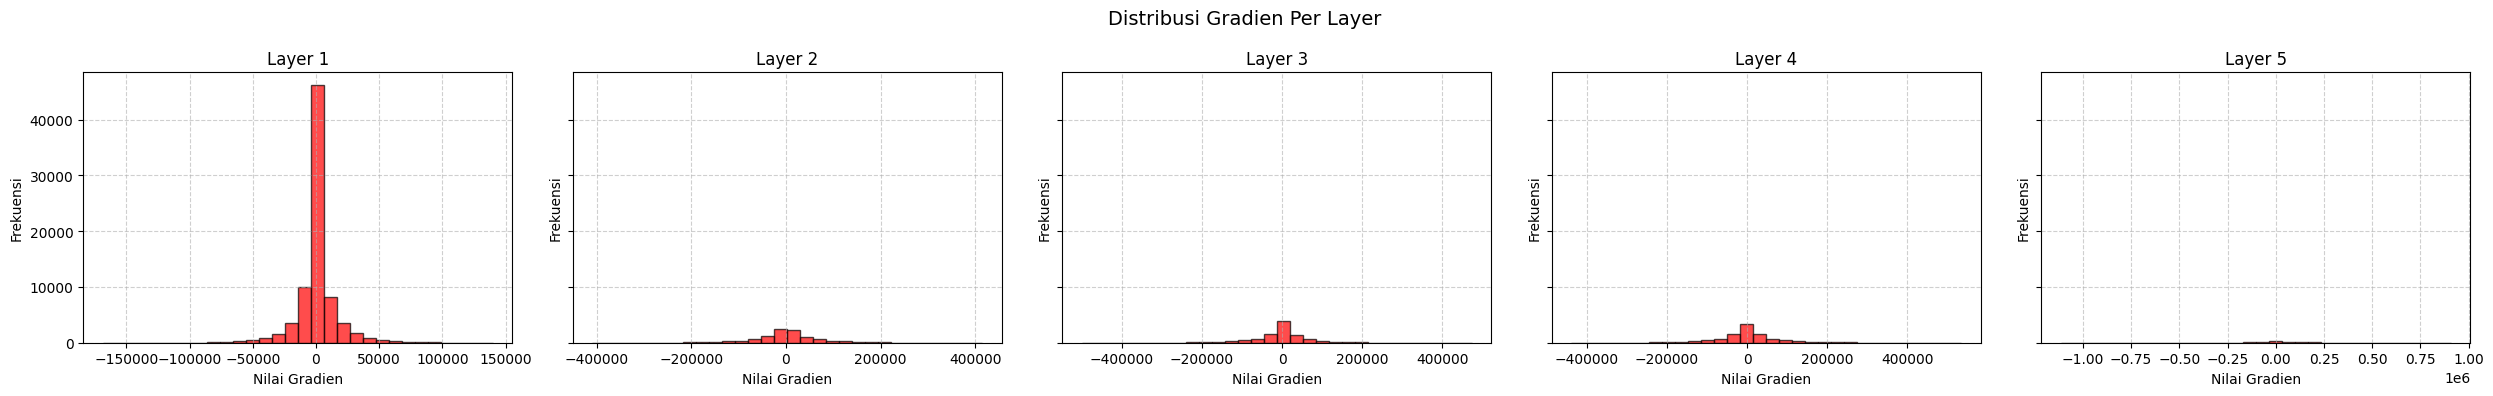


 Learning Rate 0.01 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0927 - Validation Loss: 0.0980 - 3.23s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.116129  | 0.087403
    2 |  0.086604  | 0.093636
    3 |  0.092712  | 0.098049


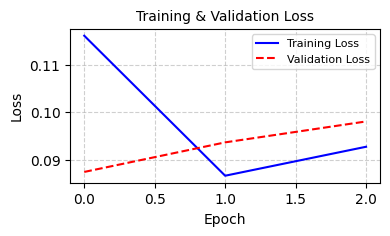

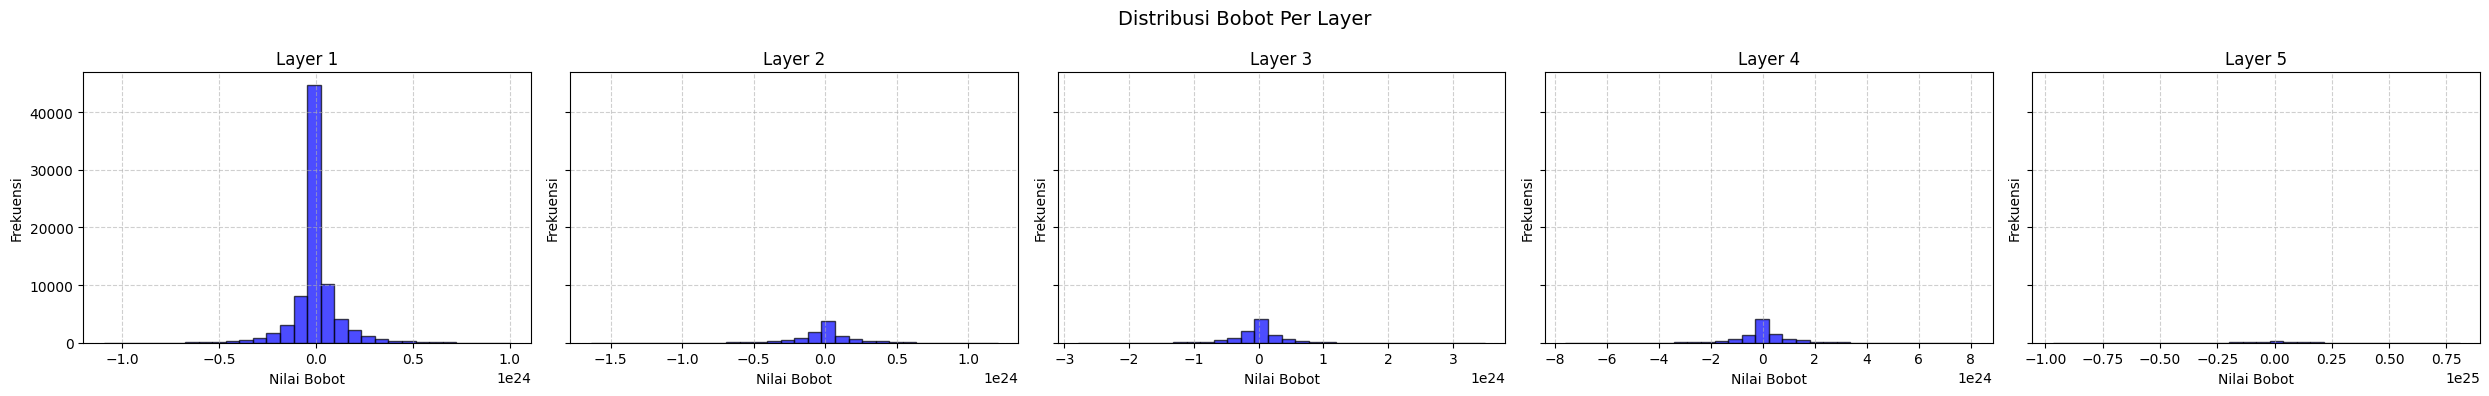

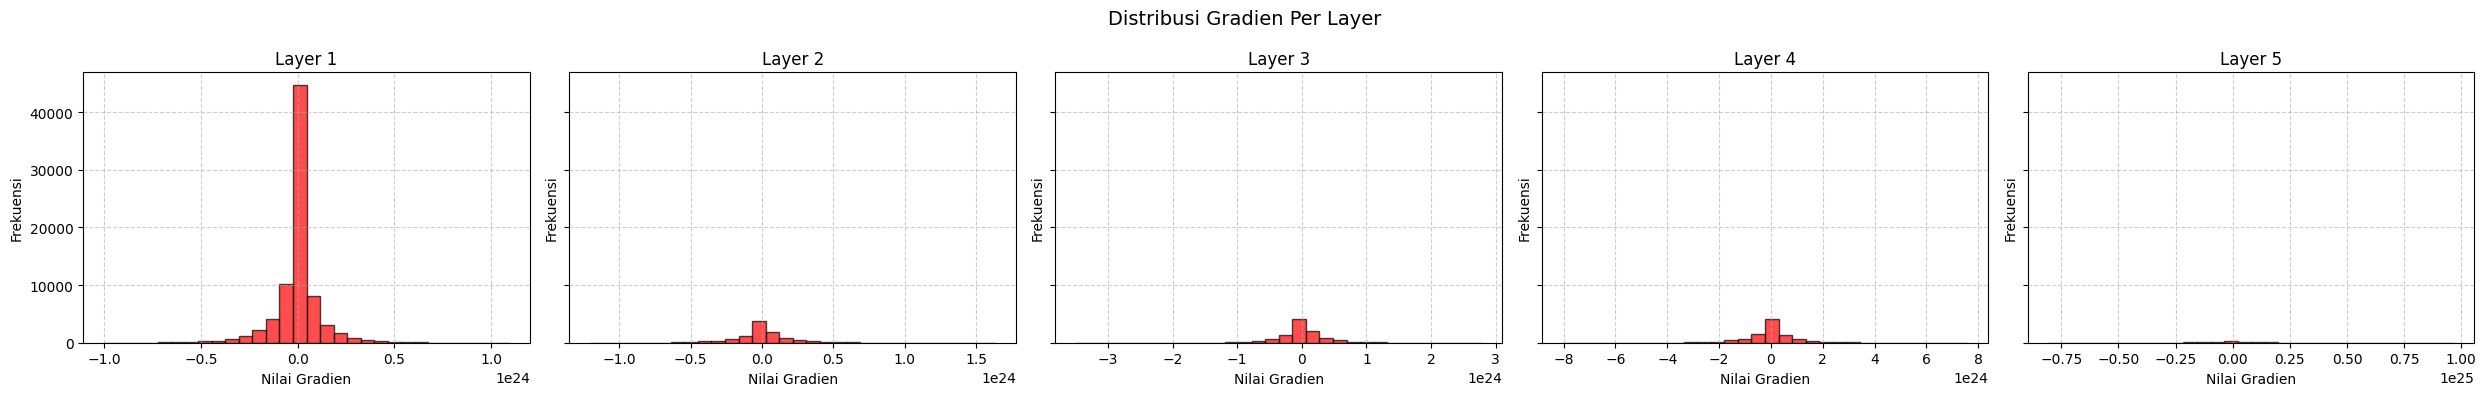


 Learning Rate 0.1 Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0927 - Validation Loss: 0.0979 - 3.17s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.116129  | 0.086761
    2 |  0.085964  | 0.093840
    3 |  0.092690  | 0.097892


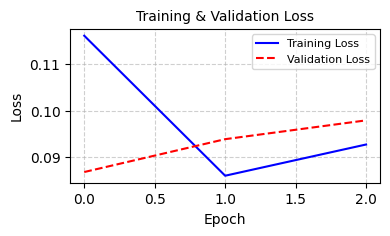

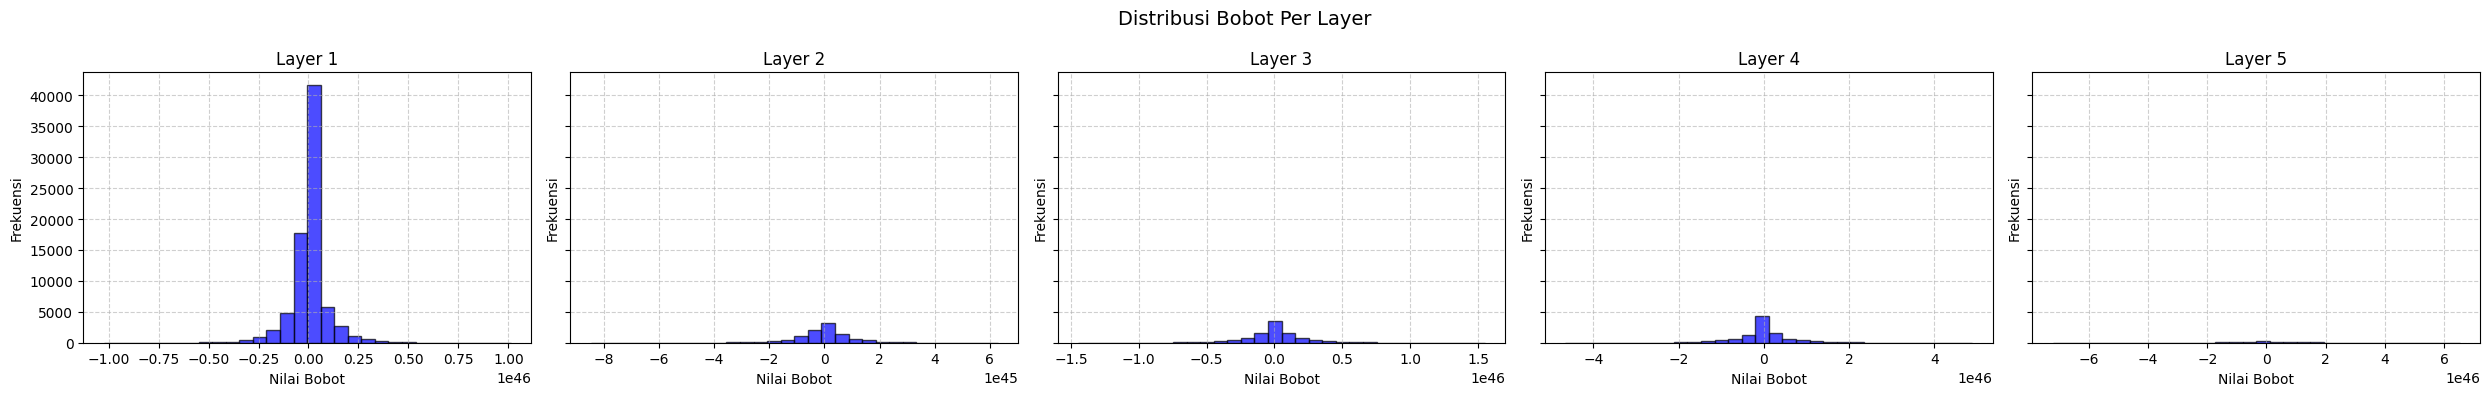

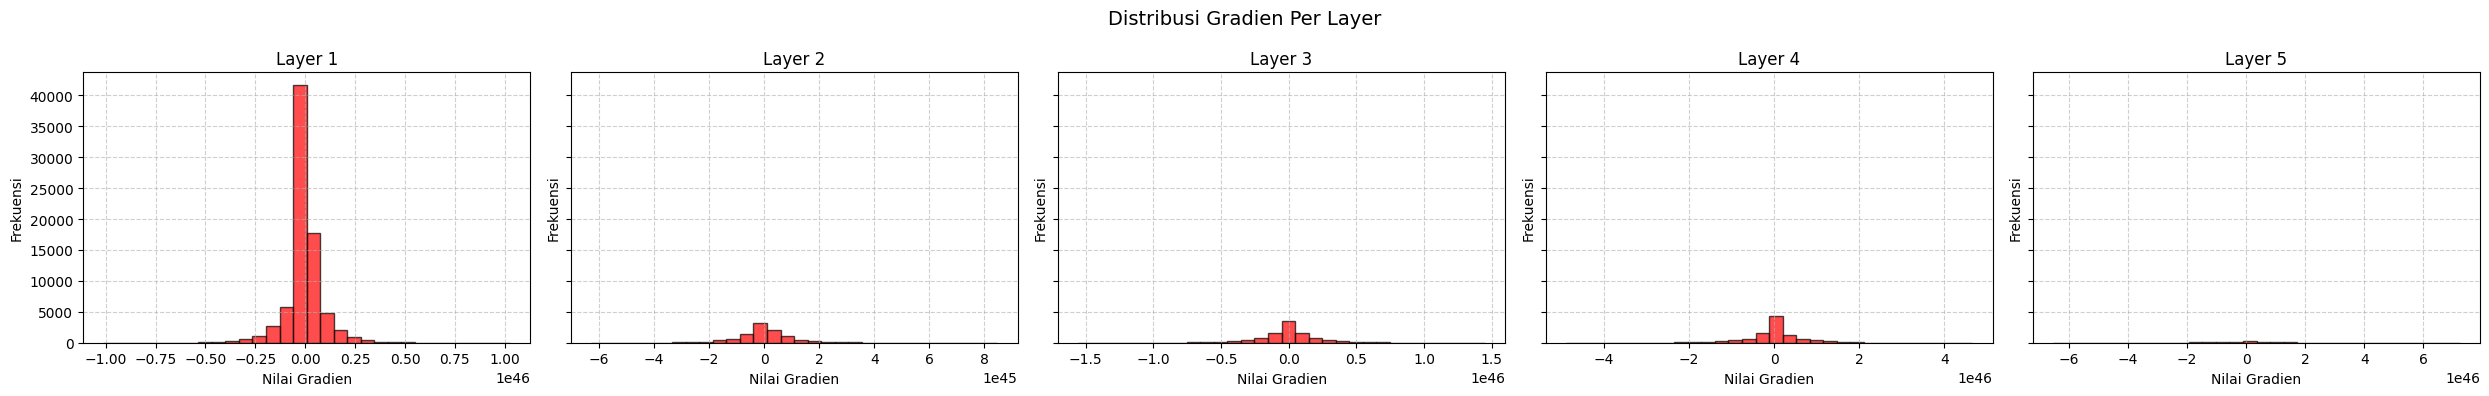

In [22]:
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f"\n Learning Rate {lr} Result\n")
    ffnn, acc = train_ffnn(depth=5, width=100, learning_rate=lr, activation=linear, weight_init='uniform')
    results[f"LR {lr}"] = acc

    Dari hasil uji coba, penggunaan learning rate 0.01 memberikan nilai yang optimal. Hal ini bisa dilihat dari nilai validation error yang paling rendah, meskipun terjadi overfit. Model dengan learning rate 0.1 memberikan nilai validation error nya semakin meningkat dan modelnya lebih overfitting dari model sebelumnya. Terakhir, model dengan learning rate 0.001 menghasilkan model paling underfitting karena nilai validation loss-nya  paling tinggi terlihat pada grafik validation yang meningkat tajam.

    Pada learning rate 0.001, distribusi bobot masih relatif normal dan terpusat di sekitar nol, menunjukkan pembelajaran berlangsung dengan stabil. Ketika learning rate meningkat menjadi 0.01, nilai bobot mulai membesar dengan beberapa nilai ekstrim, menandakan adanya peningkatan variabilitas dalam pembaruan bobot. Pada learning rate 0.1, distribusi bobot semakin menyebar luas dengan nilai yang jauh lebih besar, yang mengindikasikan kemungkinan exploding gradient atau pembaruan bobot menjadi terlalu besar akibat akumulasi gradien yang terus meningkat, menyebabkan nilai bobot membesar secara tidak terkendali. Hal ini dapat menghambat konvergensi model dan bahkan membuat training menjadi tidak stabil. Oleh karena itu, bisa disimpulkan bahwa semakin tinggi nilai learning rate menyebabkan bobot model membesar secara tidak stabil, yang dapat mengarah ke divergensi selama training.


    Pada learning rate 0.001, distribusi gradien masih cukup normal dengan rentang nilai yang terkendali dan mayoritas berada di sekitar nol. Ketika learning rate dinaikkan menjadi 0.01, mulai muncul nilai gradien yang lebih besar, dengan beberapa layer menunjukkan rentang hingga orde 10²⁴. Meskipun mayoritas nilai masih berada di sekitar nol, adanya nilai ekstrem ini mengindikasikan awal dari exploding gradient, di mana pembaruan bobot mulai tidak stabil. Pada learning rate 0.1, eksplosi gradien terjadi lebih buruk, dengan nilai yang meningkat drastis hingga skala 10⁴⁶. Meskipun distribusi masih tampak terpusat di nol, skala yang sangat besar menunjukkan bahwa model mengalami perubahan bobot yang ekstrem, yang dapat menyebabkan kesulitan dalam melakukan konvergensi. Dari pola distribusi ini, terlihat bahwa semakin besar learning rate, semakin besar pula kemungkinan eksplosi gradien, yang pada akhirnya dapat menghambat proses training model.


### Pengaruh Inisialisasi Bobot


 zero weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0900 - Validation Loss: 0.0900 - 3.53s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.090000  | 0.090000
    2 |  0.089993  | 0.090000
    3 |  0.089988  | 0.090000


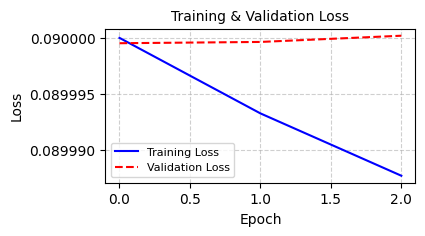

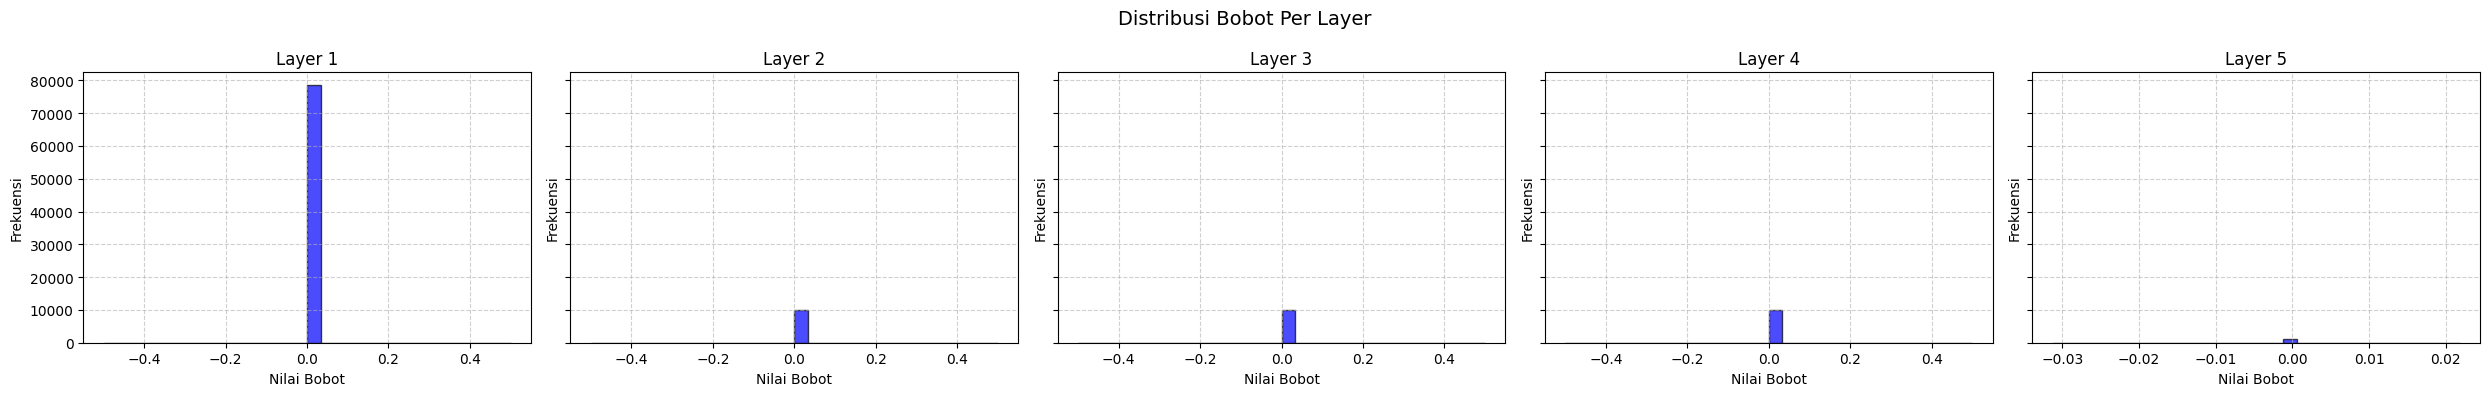

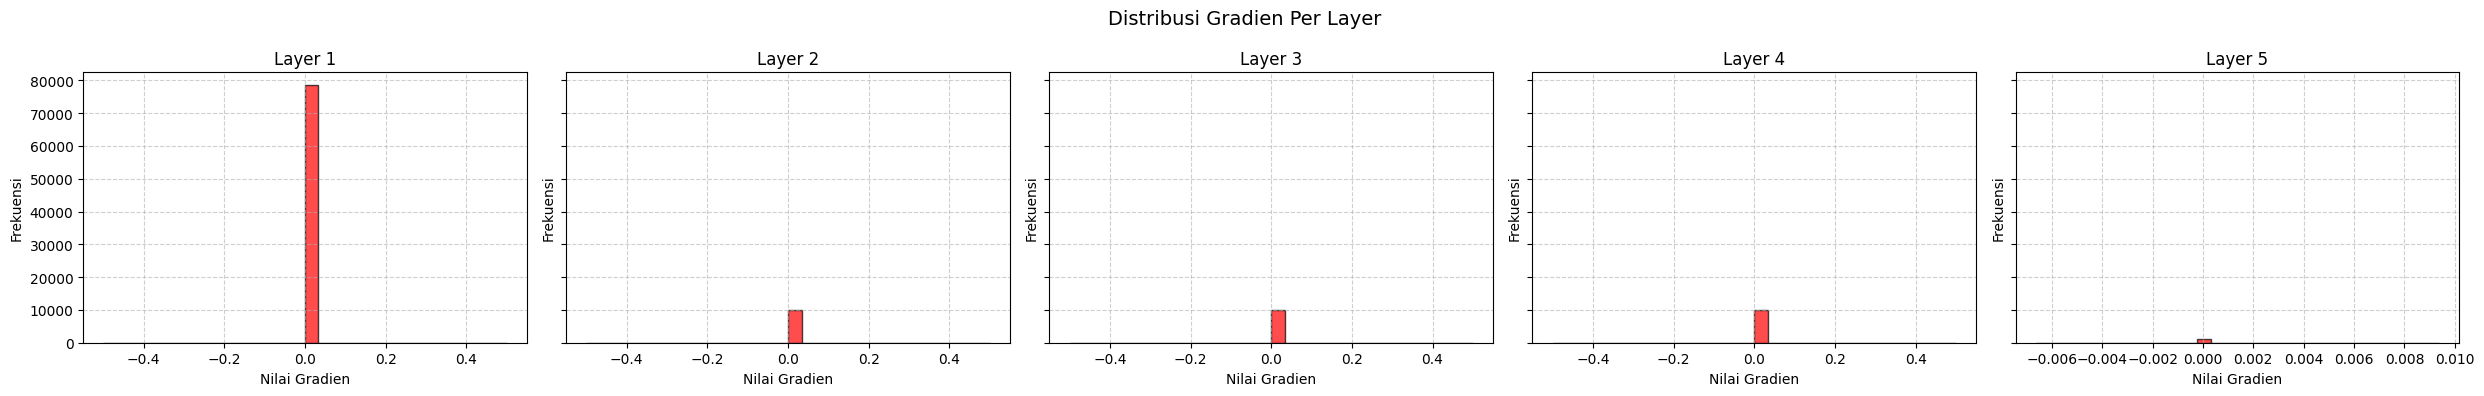


 normal weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1008 - Validation Loss: 0.0955 - 3.29s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.102074  | 0.090284
    2 |  0.090325  | 0.100493
    3 |  0.100777  | 0.095512


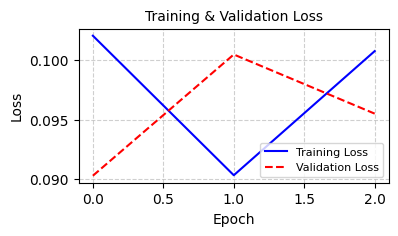

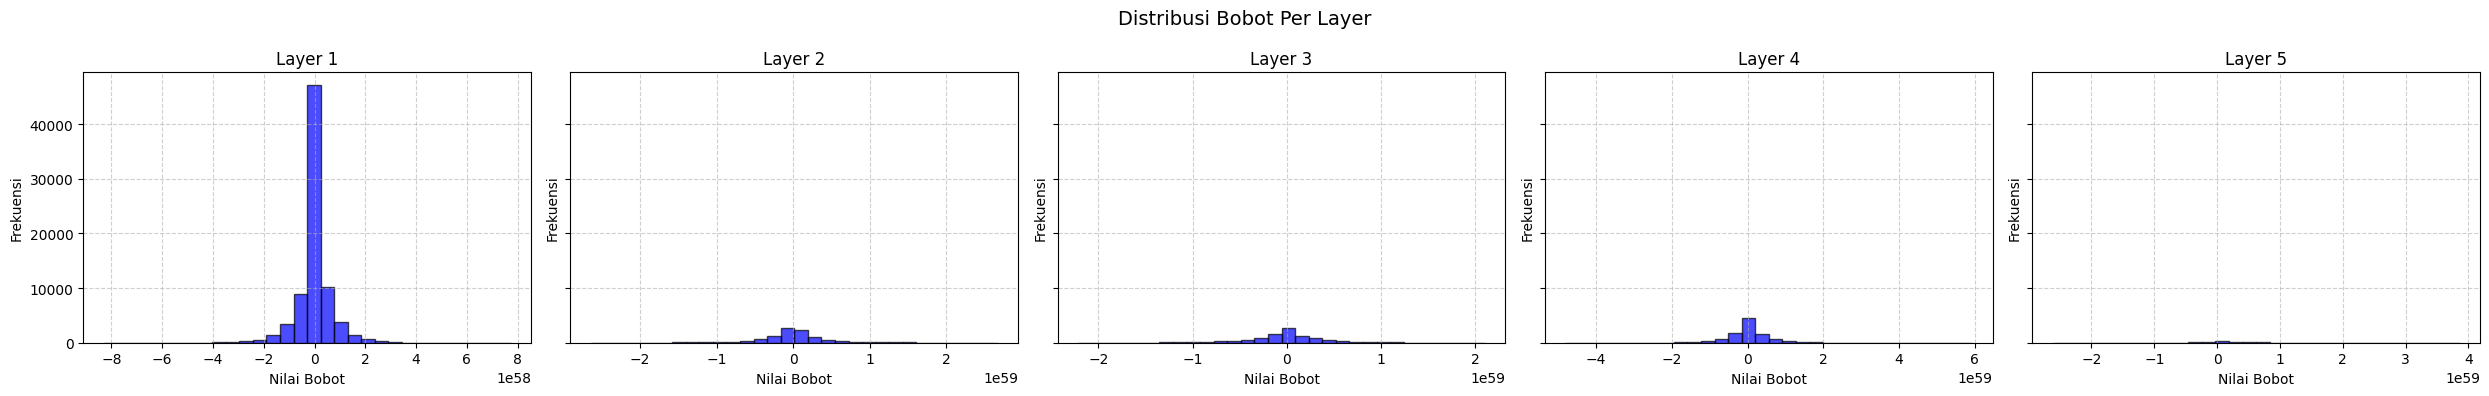

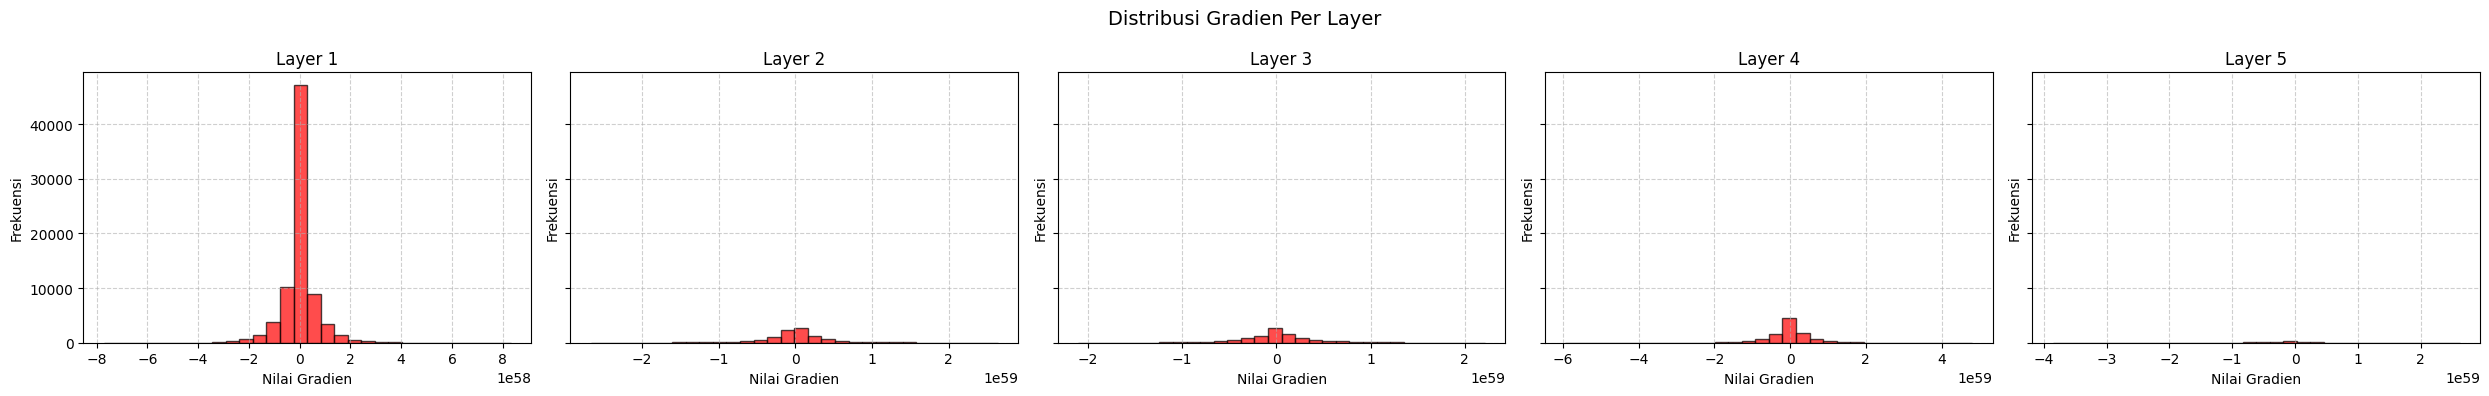


 uniform weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0927 - Validation Loss: 0.0980 - 3.18s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.116129  | 0.087403
    2 |  0.086604  | 0.093636
    3 |  0.092712  | 0.098049


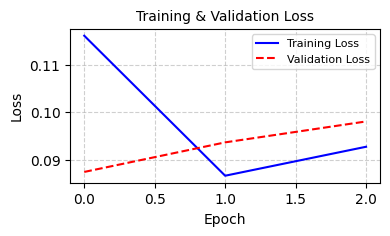

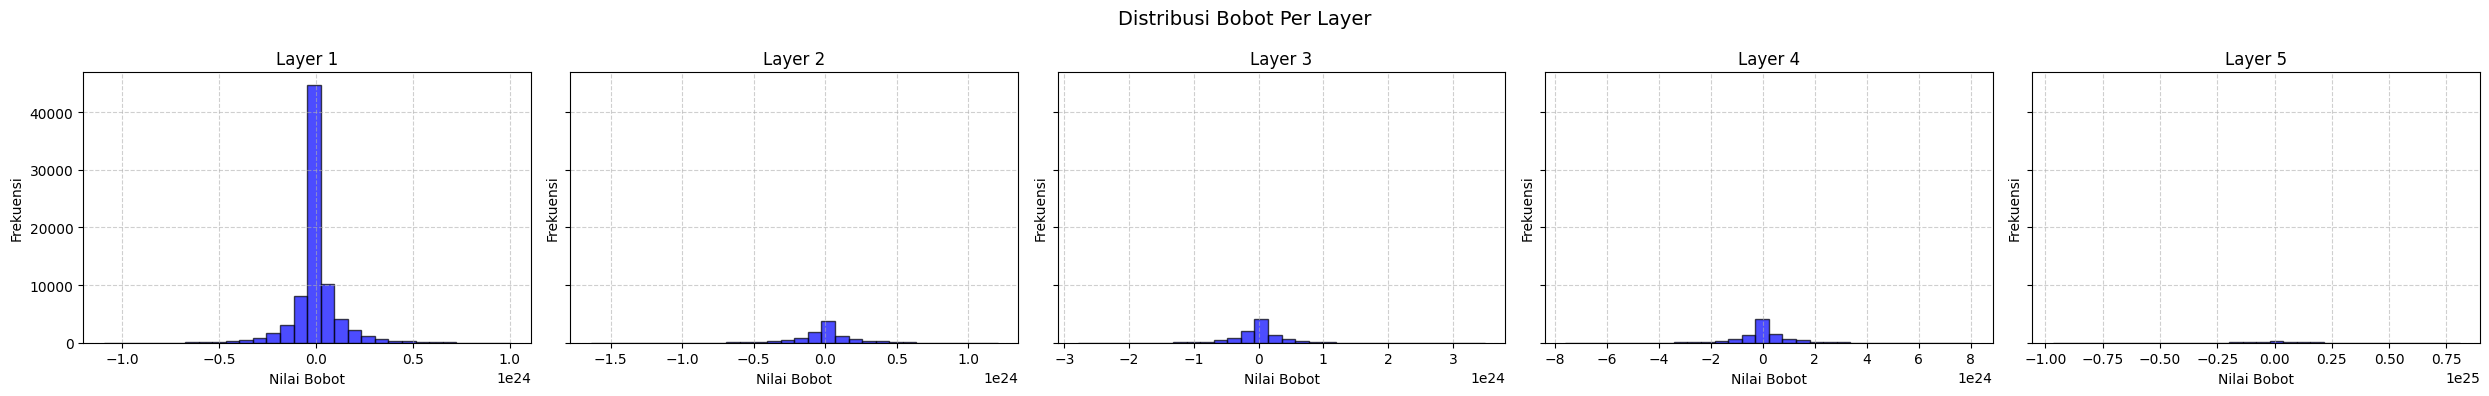

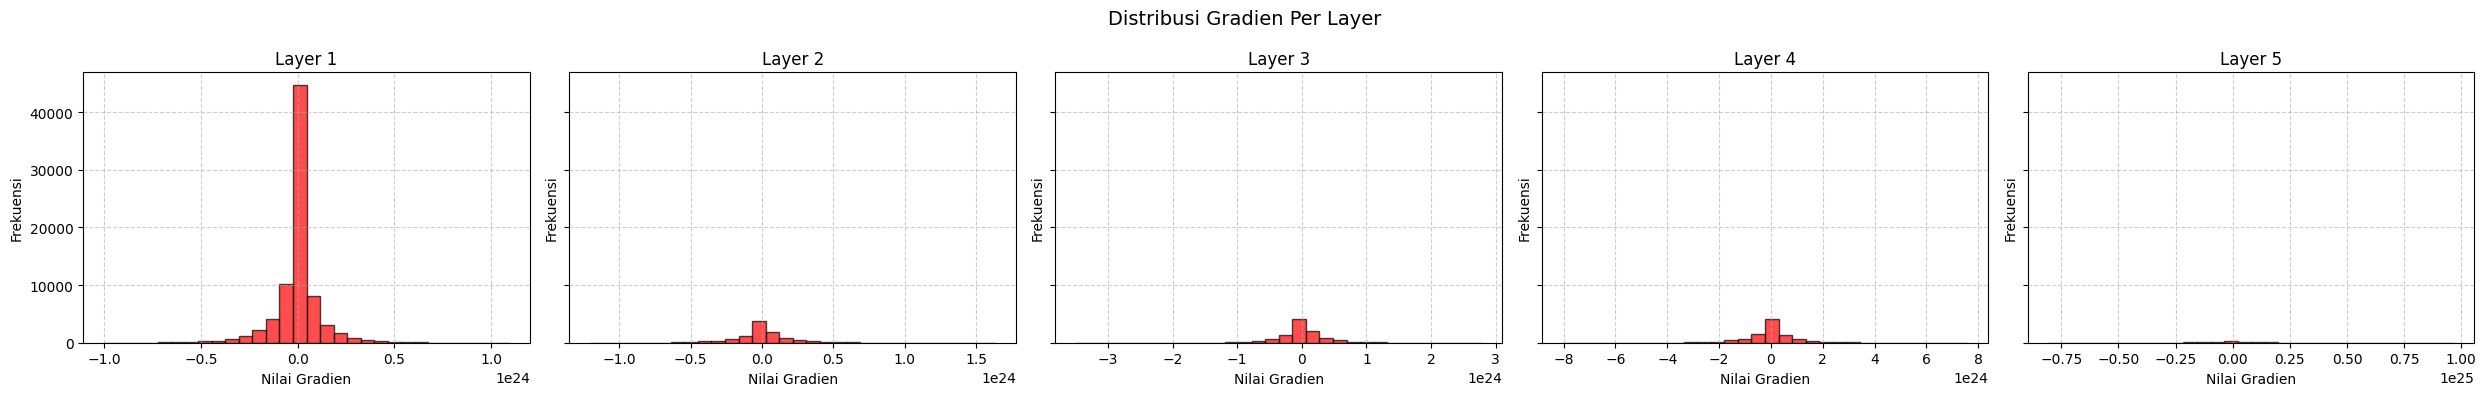


 xavier weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1336 - Validation Loss: 0.1021 - 3.18s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.106224  | 0.149273
    2 |  0.149801  | 0.134843
    3 |  0.133649  | 0.102080


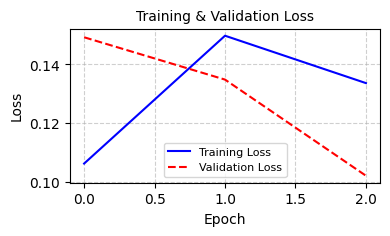

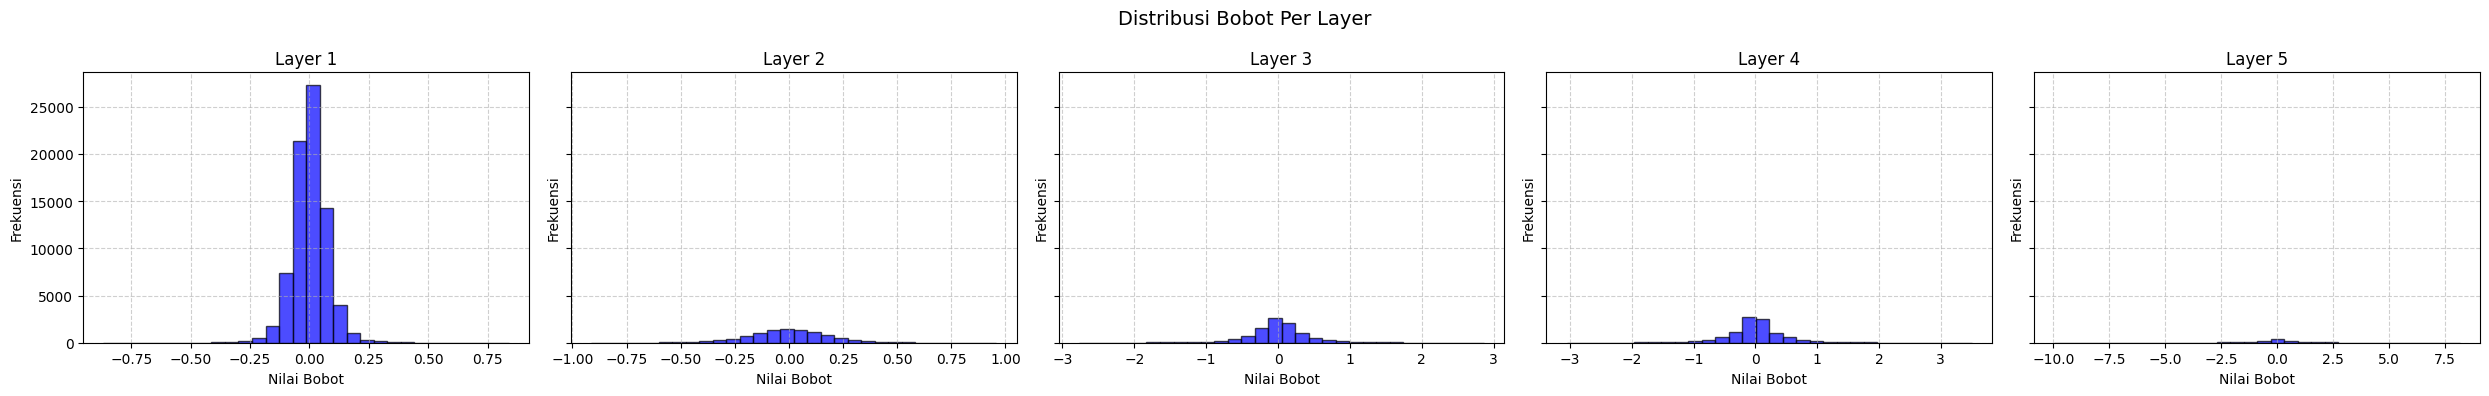

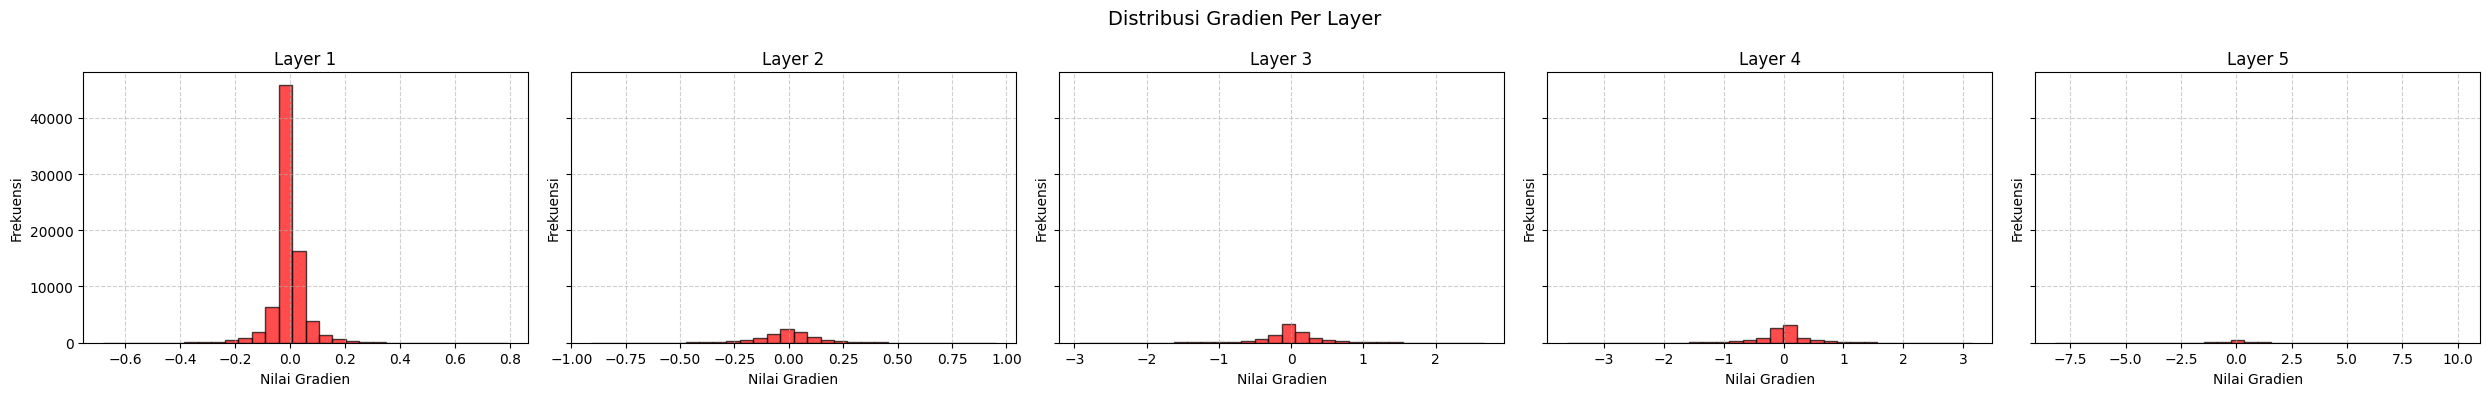


 he weight initializations Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1248 - Validation Loss: 0.0955 - 3.19s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.143884  | 0.185810
    2 |  0.185775  | 0.127237
    3 |  0.124841  | 0.095548


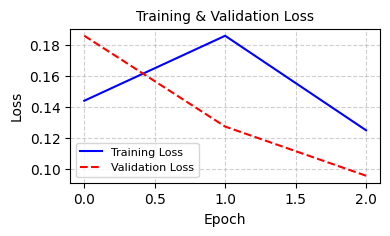

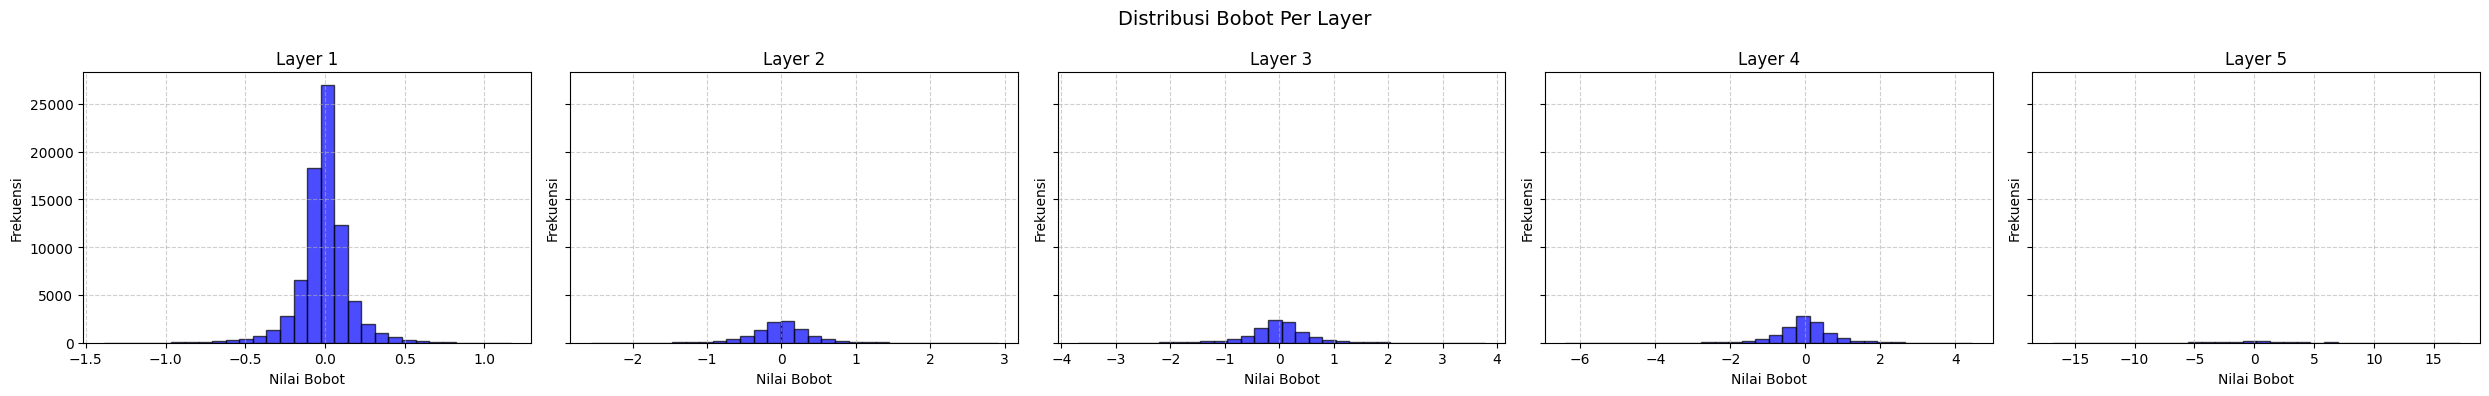

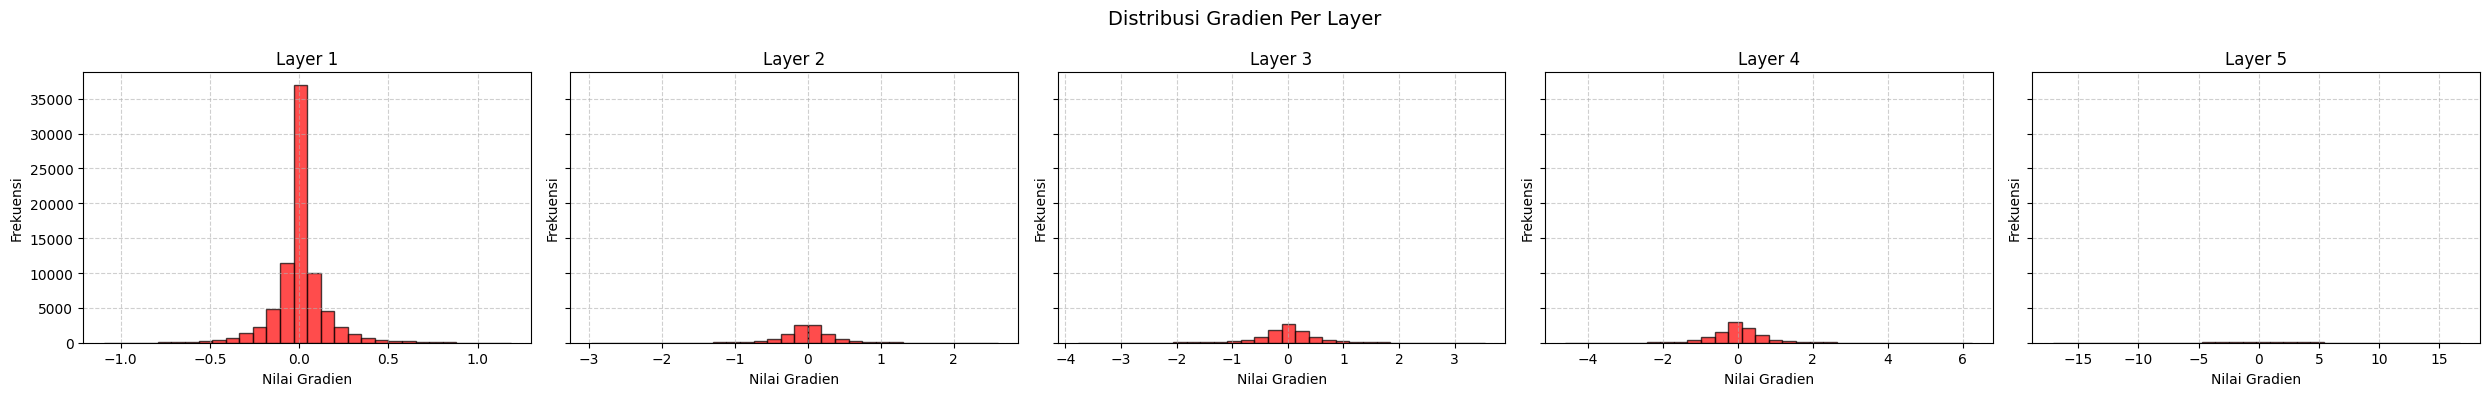

In [23]:
weight_initializations = ['zero','normal', 'uniform','xavier', 'he']

for init in weight_initializations:
    print(f"\n {init} weight initializations Result\n")
    ffnn, acc = train_ffnn(depth=5, width=100, learning_rate=0.01, activation=linear, weight_init=init)
    results[f"Weight Init {init}"] = acc

    Dari hasil uji coba, penggunaan inisialisasi He weight memberikan model  yang optimal. Hal ini bisa dilihat dari grafik validation error yang menurun dengan nilai loss validation akhir 0.107, meskipun bukan terendah akan tetapi memiliki selisih yang tidak berbeda jauh dengan zero weight (0.0900) dan menunjukkan model tidak overfitting. Pada zero weight proses penurunan loss terjadi sangat lambat sehingga perubahan loss yang terjadi pada tiap epoch tidak signifikan. Sedangkan inisialisasi uniform menghasilkan model yang overfit karena nilai validation nya naik. Begitu pula dengan model lain yang juga menunjukkan hasil yang cenderung overfit. 


    Dari berbagai metode inisialisasi bobot, Xavier dan He Weight menunjukkan distribusi bobot yang lebih stabil dibandingkan metode lainnya, menjadikannya pilihan terbaik. Zero Weight menyebabkan semua neuron memiliki output yang sama. Normal weight dan Uniform Weight cenderung mengalami distribusi bobot pada layer yang lebih tinggi, yang dapat menyebabkan menurunnya nilai gradien saat backpropagation. Dengan demikian, pemilihan metode inisialisasi yang tepat dapat berpengaruh terhadap stabilitas dan konvergensi model selama proses training.


    Dari analisis distribusi gradien pada berbagai metode inisialisasi bobot, terlihat bahwa Zero Weight menyebabkan gradien seluruh layer bernilai nol, yang menyebabkan model tidak melakukan pembelajaran karena backpropagation tidak berjalan. Normal Weight dan Uniform Weight menghasilkan gradien yang terlalu besar di beberapa layer, berpotensi menyebabkan exploding gradient. Xavier mendistribusikan gradien dengan lebih stabil di seluruh layer, cocok untuk aktivasi sigmoid dan tanh, sedangkan He mempertahankan distribusi gradien dengan lebih baik, terutama untuk ReLU, sehingga mengurangi risiko vanishing gradient. 


### Pengaruh Fungsi Aktivasi


 tanh activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0858 - Validation Loss: 0.1272 - 3.68s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.127579  | 0.079662
    2 |  0.079787  | 0.089047
    3 |  0.085807  | 0.127245


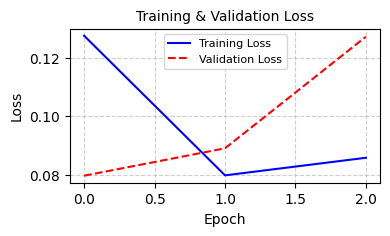

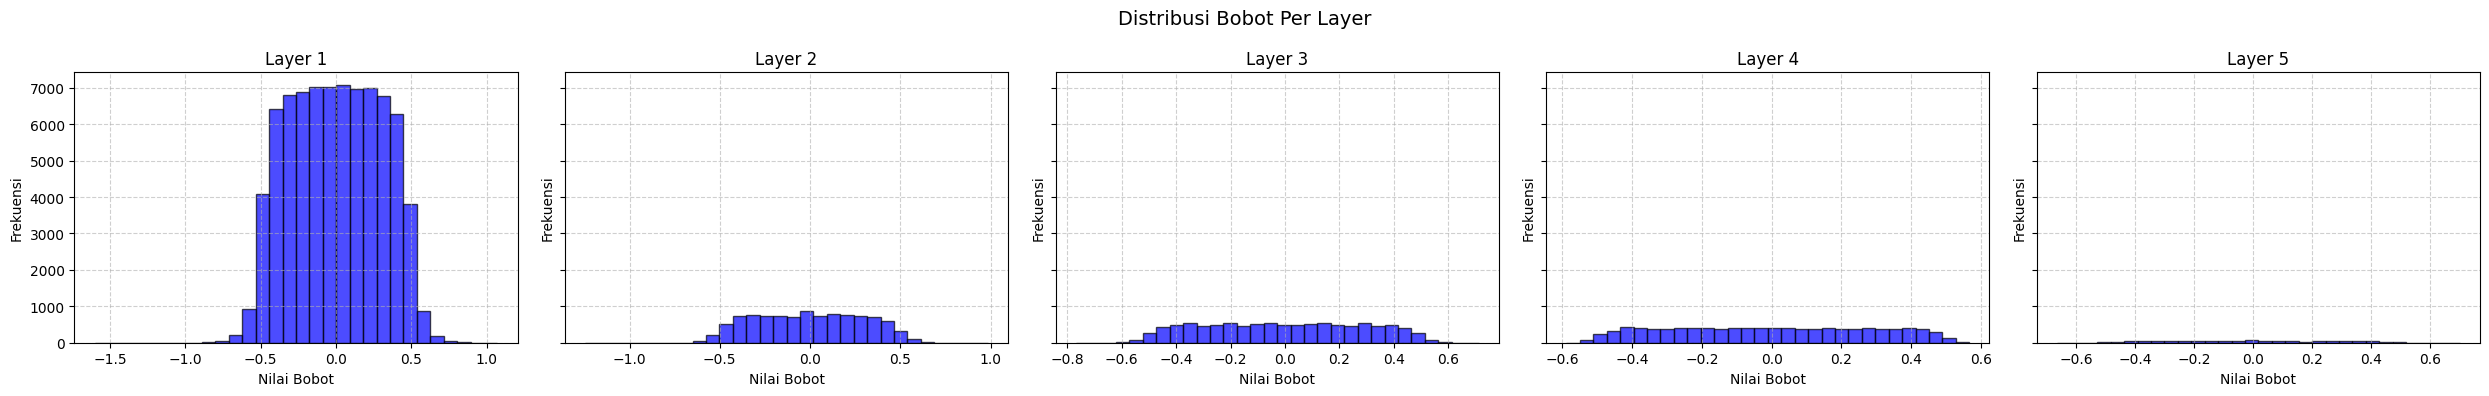

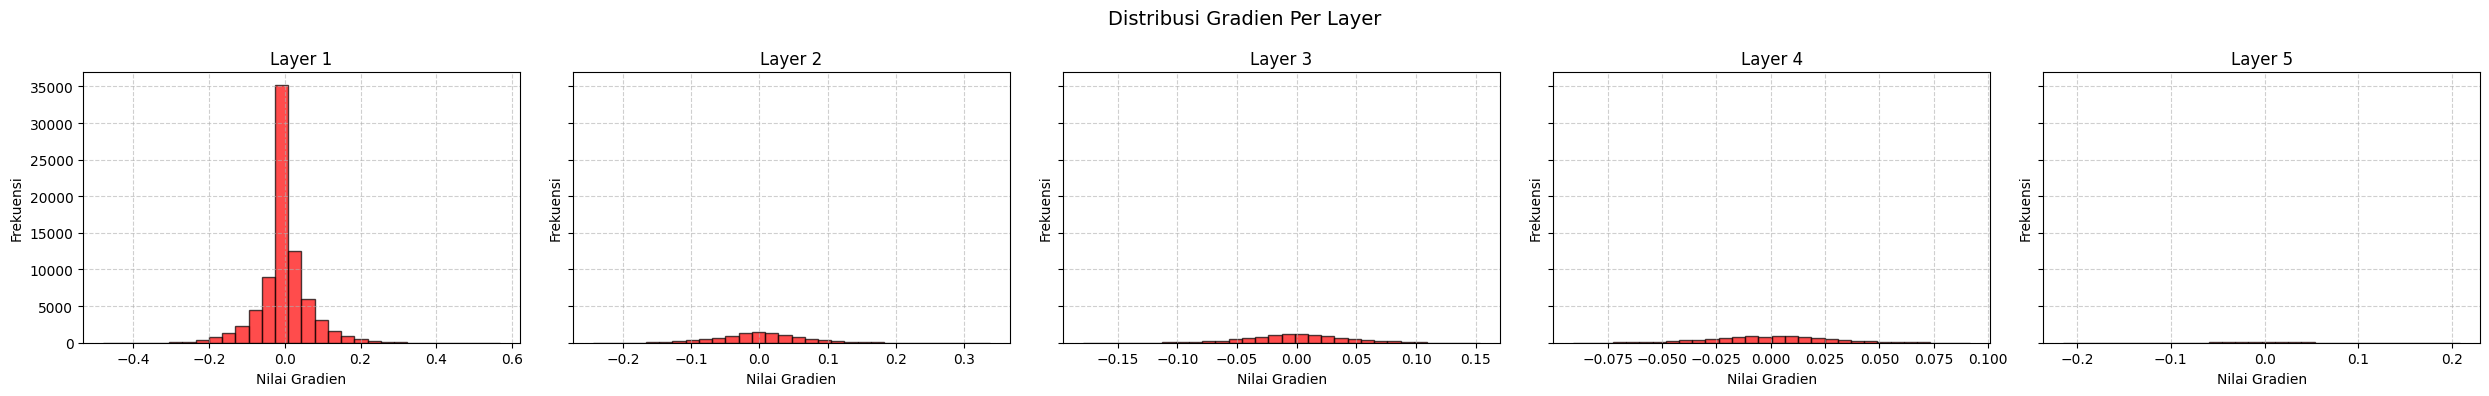


 sigmoid activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1170 - Validation Loss: 0.1152 - 3.69s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.111453  | 0.099815
    2 |  0.099914  | 0.116734
    3 |  0.117006  | 0.115157


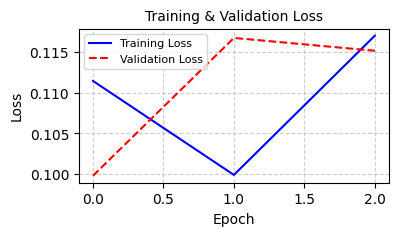

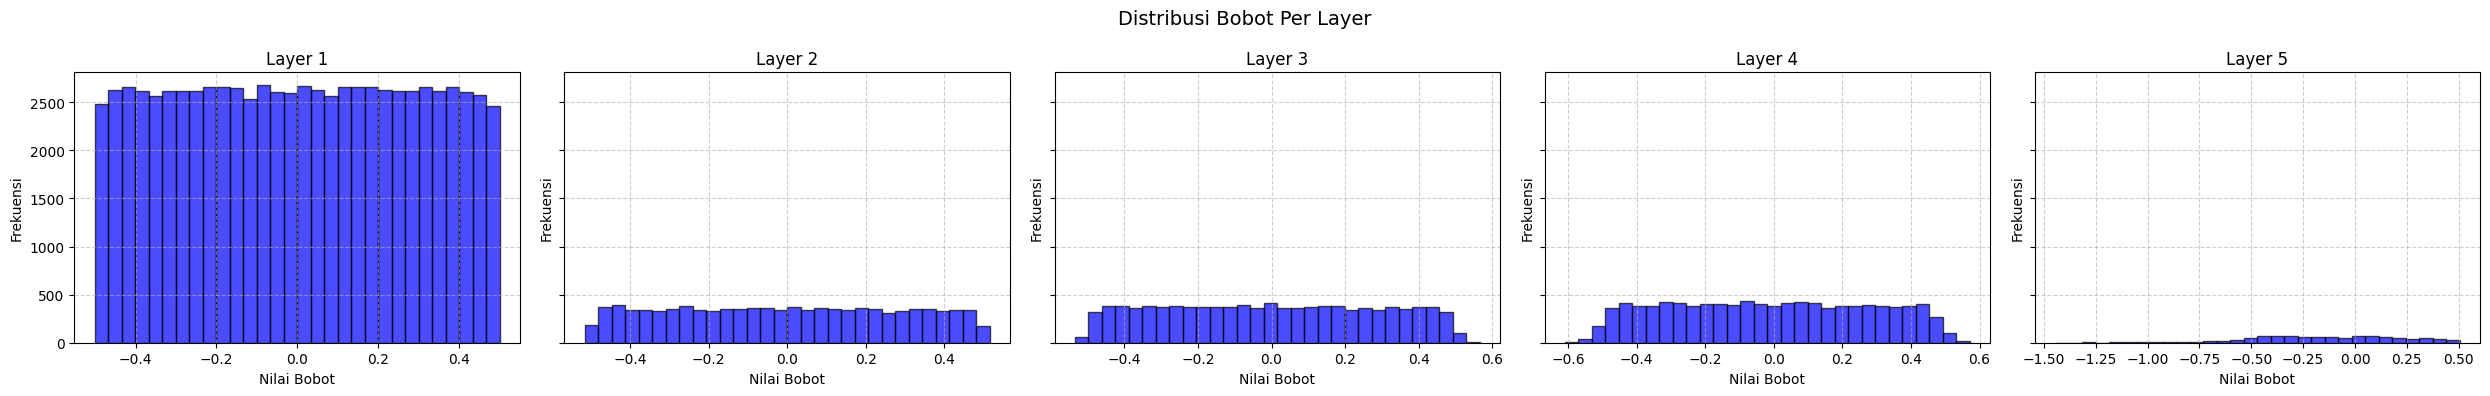

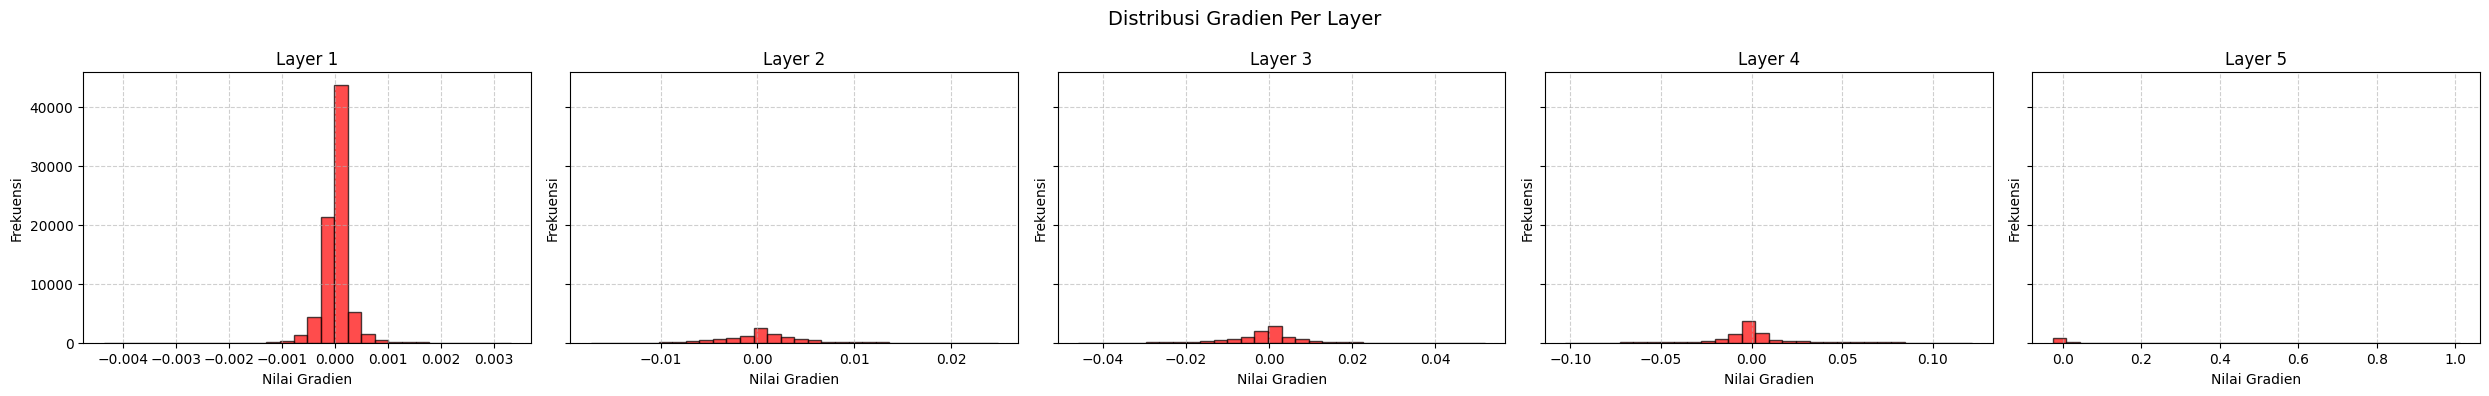


 relu activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.1041 - Validation Loss: 0.1303 - 3.41s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.169032  | 0.090000
    2 |  0.090000  | 0.104780
    3 |  0.104120  | 0.130320


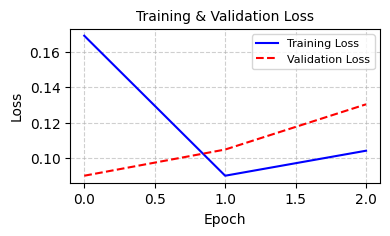

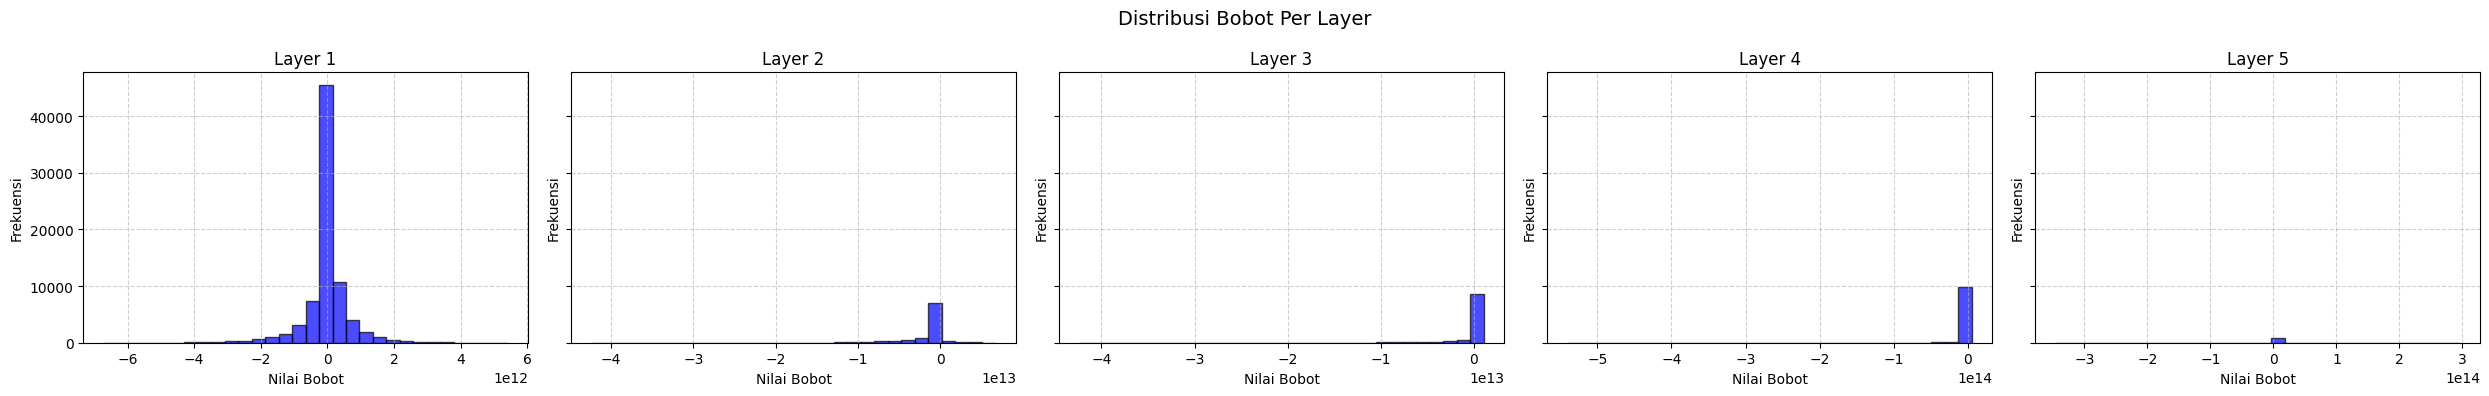

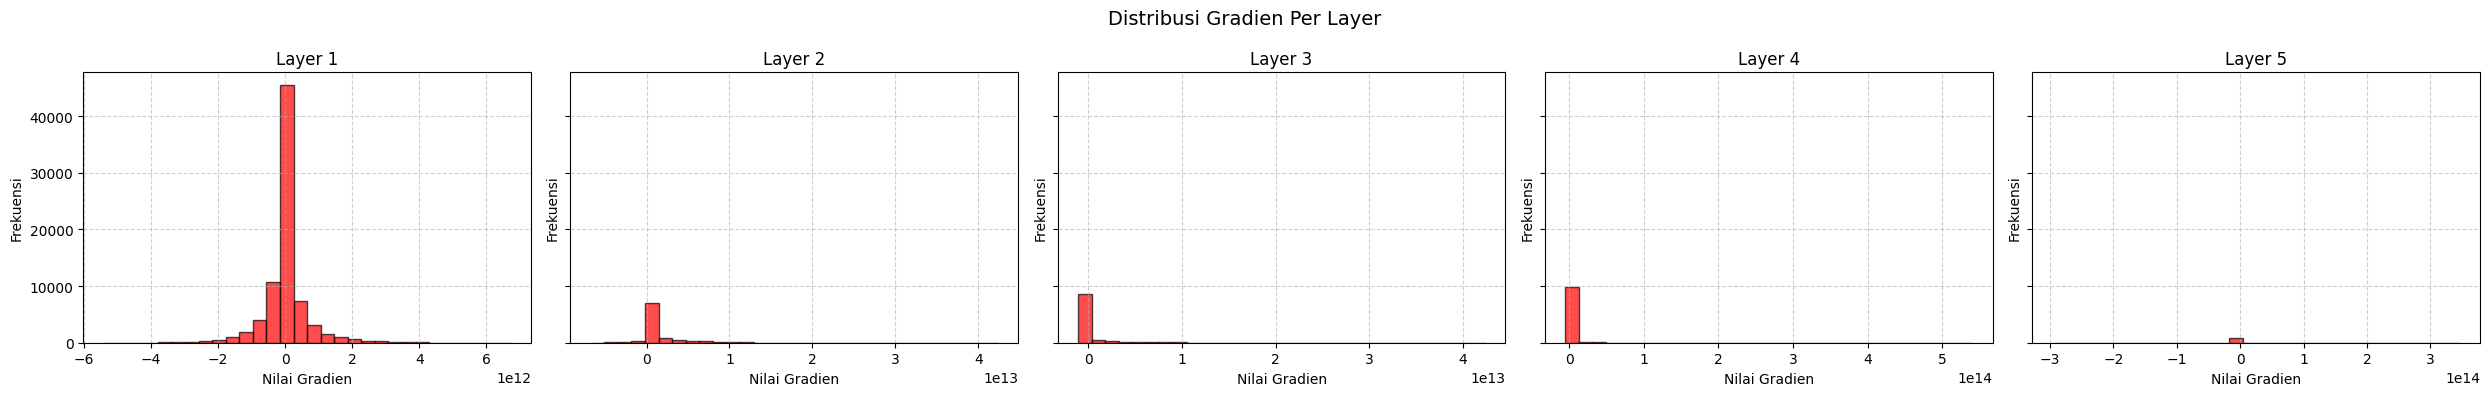


 linear activation Result

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0927 - Validation Loss: 0.0980 - 3.35s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.116129  | 0.087403
    2 |  0.086604  | 0.093636
    3 |  0.092712  | 0.098049


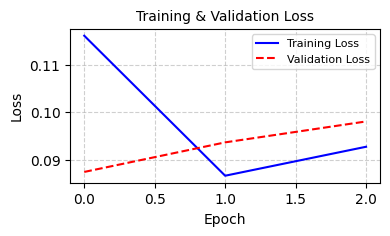

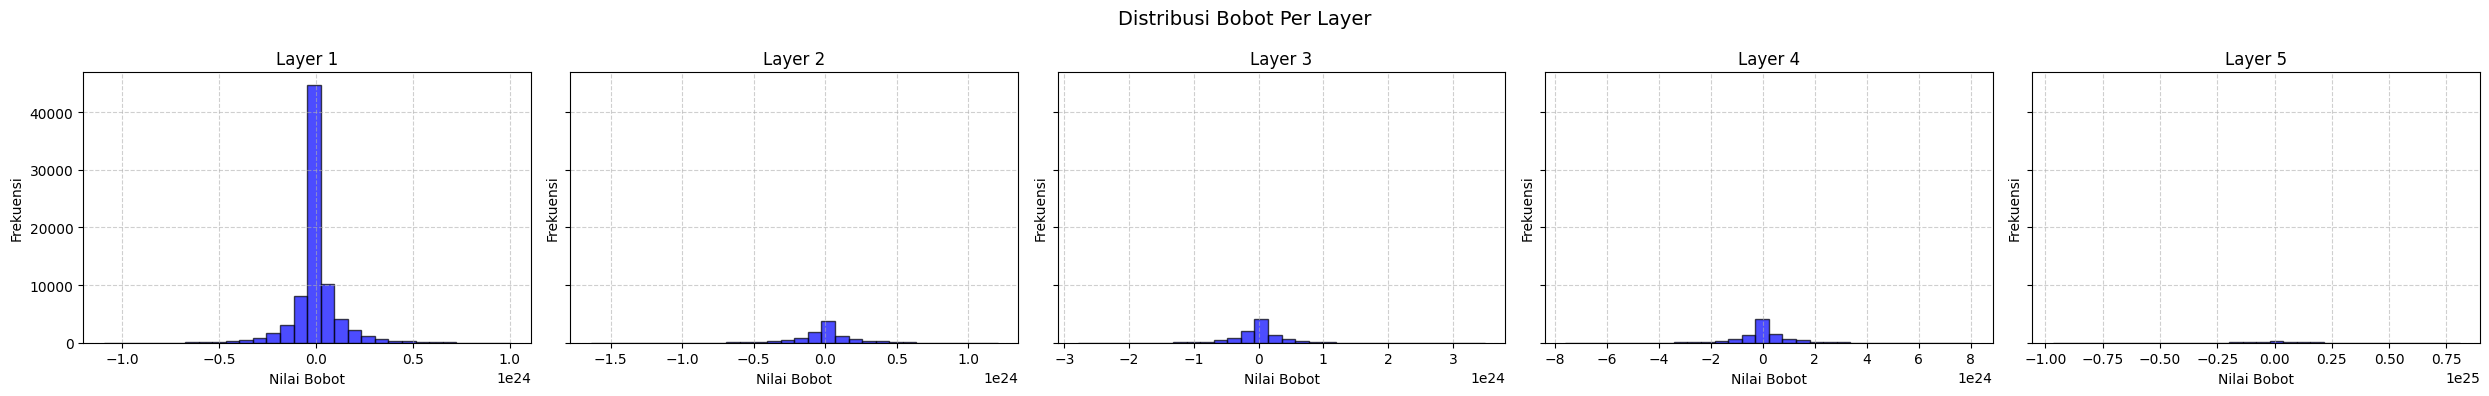

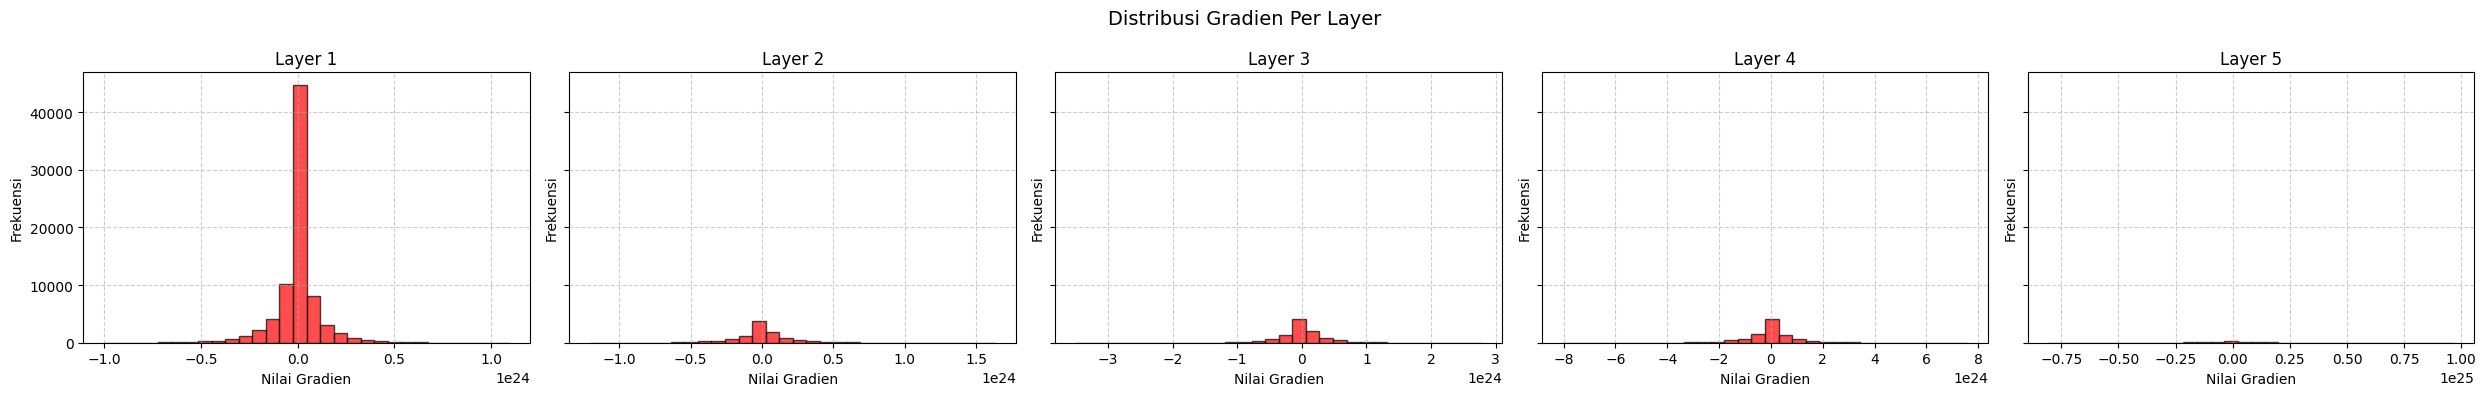

In [24]:
activations = [tanh, sigmoid, relu, linear]

for activation in activations:
    print(f"\n {activation.__name__} activation Result\n")
    ffnn, acc = train_ffnn(depth=5, width=100, learning_rate=0.01, activation=activation, weight_init='uniform')
    results[f"Activation {activation.__name__}"] = acc


    Fungsi aktivasi tanh memberikan nilai training loss yang menurun akan tetapi validation loss meningkat setelah epoch pertama yang mengindikasikan bahwa model ini mengalami overfitting pada train data. Selanjutnya, fungsi aktivasi sigmoid memberikan nilai training loss yang awalnya turun kemudian naik setelah epoch pertama. Sebaliknya nilai validation nya awalnya naik kemudian turun. Hal ini mengindikasikan model ini mengalami kesulitan dalam konvergensi kemungkinan karena terjadi vanishing gradient pada lapisan yang lebih dalam. Selanjutnya fungsi aktivasi ReLU memberikan nilai training loss turun kemudian naik sedangkan validation-nya naik kemudian turun yang mengindikasikan model tidak overfit. Terakhir, fungsi aktivasi Linear memberikan nilai training loss turun kemudian naik dan nilai loss validation-nya meningkat yang mengindikasikan model mengalami overfitting. Sehingga bisa disimpulkan ReLU memberikan model yang optimal karena memberikan model yang tidak overfit dan memberikan nilai validation loss paling kecil. 

    Hasil distribusi bobot menunjukkan bahwa fungsi aktivasi tanh dan Sigmoid mengalami vanishing gradient, di mana nilai bobot mendekati nol seiring bertambahnya kedalaman layer, menyebabkan sulit untuk melakukan pembaruan bobot dan training model menjadi lambat. Sementara itu, ReLU cenderung mengalami exploding gradient, dengan distribusi bobot yang lebih luas di layer lebih dalam. Sedangkan pada Linear, eksploding gradient terjadi lebih buruk dengan distribusi bobot yang membesar dan mengecil secara acak. Akibatnya, model dengan aktivasi Linear mengalami training loss yang turun lalu naik kembali, serta validation loss yang meningkat, mengindikasikan terjadi overfitting. Oleh karena itu, ReLU menjadi model yang paling optimal daripada tanh, Sigmoid, atau Linear karena perubahan bobotnya lebih stabil.

    Hasil distribusi gradient menunjukkan fungsi aktivasi Tanh dan Sigmoid mengalami pelemahan dengan gradien yang mendekati nol seiring bertambahnya kedalaman layer, menyebabkan masalah vanishing gradient yang menghambat proses pembaruan bobot dan memperlambat training. Sementara itu, ReLU cenderung mengalami peningkatan distribusi nilai gradien di layer lebih dalam, yang juga dapat menyebabkan exploding gradient, tetapi tetap lebih terkendali dibandingkan Linear, yang menunjukkan distribusi gradien yang acak. Akibatnya, model dengan aktivasi Linear berisiko mengalami ketidakstabilan selama training, dengan perubahan yang menurun dan meningkat pada training loss dan validation loss yang terus meningkat. Oleh karena itu, ReLU lebih disarankan dibandingkan Tanh, Sigmoid, atau Linear karena distribusi gradien nya lebih stabil dalam mempertahankan pembaruan bobot selama proses training.


### Perbandingan dengan MLP

Epoch 3/3 [==============================] 100.0% - Training Loss: 0.0900 - Validation Loss: 0.1002 - 2.92s/epoch - ETA: 0.00s
         Training History          
Epoch | Train Loss | Val Loss
-----------------------------------
    1 |  0.098664  | 0.165055
    2 |  0.162430  | 0.090000
    3 |  0.090000  | 0.100232


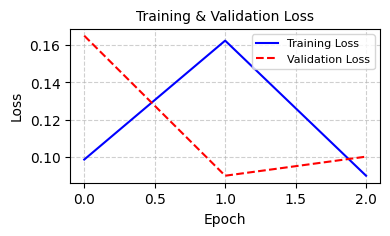

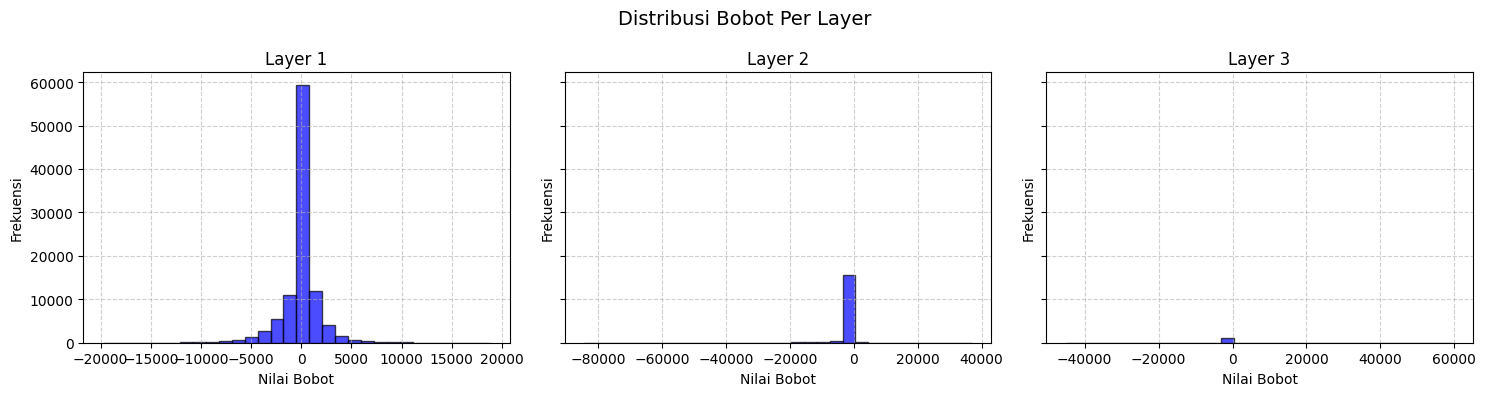

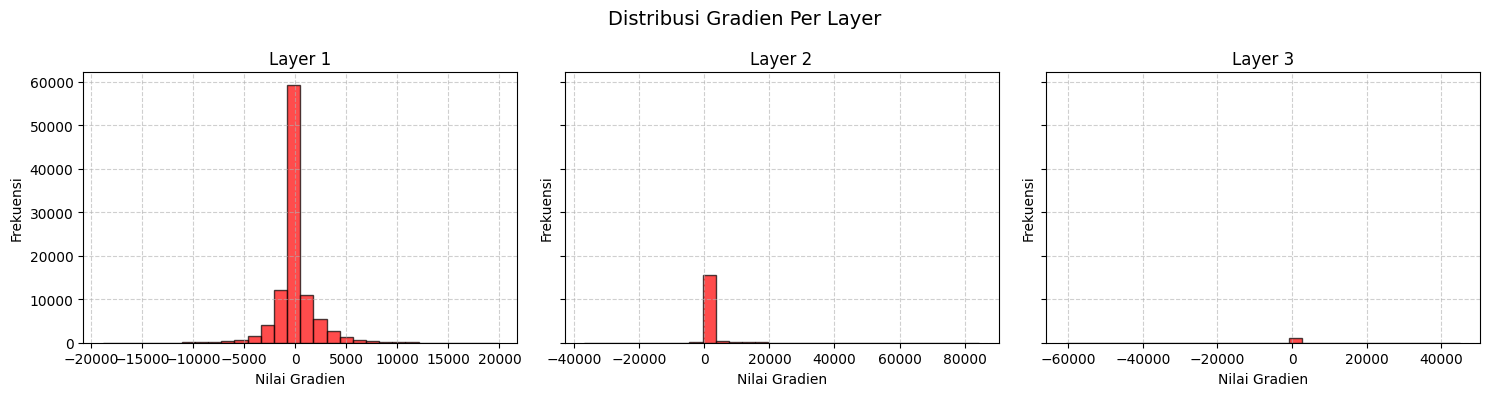

In [25]:
depth = 3
width = 128
learning_rate = 0.01
activation = relu
weight_init = 'normal'

ffnn, accuracy_ffnn = train_ffnn(depth=depth, width=width, learning_rate=learning_rate, activation=activation, weight_init=weight_init)

y_pred_ffnn = ffnn.predict(X_test)
y_pred_labels_ffnn = np.argmax(y_pred_ffnn, axis=1)


In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(width,) * (depth - 1),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=learning_rate,
                    max_iter=3,
                    random_state=42)

mlp.fit(X_train, np.argmax(y_train_oh, axis=1))

y_pred_sklearn = mlp.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
print(f"Akurasi Model FFNN      : {accuracy_ffnn:.2f}%")
print(f"Akurasi MLP Sklearn     : {accuracy_sklearn:.2f}%")


Akurasi Model FFNN      : 10.27%
Akurasi MLP Sklearn     : 0.93%


    Berdasarkan hasil pengujian dengan parameter yang sama, model FFNN menunjukkan akurasi 10.52%, jauh lebih tinggi dibandingkan MLP dari Sklearn yang hanya mencapai 0.92%. Perbedaan ini kemungkinan besar disebabkan oleh MLP Sklearn yang digunakan dengan parameter default tanpa tuning, sehingga tidak optimal dalam menangani dataset ini. Meski begitu hasil dari model masih menunjukkan hasil akurasi yang kecil juga. Distribusi bobot dan gradien per layer menunjukkan bahwa model mengalami vanishing gradient pada layer yang lebih dalam, yang dapat menghambat proses learning. Training loss yang meningkat juga mengindikasikan adanya overfitting atau learning rate yang tidak stabil, yang perlu diperbaiki dengan penyesuaian lebih lanjut pada parameter seperti inisialisasi bobot, fungsi aktivasi, dll.